1. Acceptance rate for each combinations:

Accessing data folder: C:/Users/ymijs/OneDrive/Documents/Internship/Data Analysis/EEG/Data/Behavioral-Tech-Test
Found file: numerosity_Zoé_2025-02-27T13_35_39.461Z_20250227_14.40.json
['[0, 0]' '[0, 1000]']
   reward_group bounds_group  total  accepted  acceptance_rate
0          High     [23, 41]      9       9.0       100.000000
1          High     [41, 59]      9       9.0       100.000000
2          High      [5, 23]      9       9.0       100.000000
3          High     [59, 77]      9       9.0       100.000000
4          High     [77, 95]      9       9.0       100.000000
5           Low     [23, 41]      9       1.0        11.111111
6           Low     [41, 59]      8       0.0         0.000000
7           Low      [5, 23]      9       1.0        11.111111
8           Low     [59, 77]      9       1.0        11.111111
9           Low     [77, 95]      9       1.0        11.111111
10   Low-Medium     [23, 41]      9       2.0        22.222222
11   Low-Medium     [41, 59]      9  

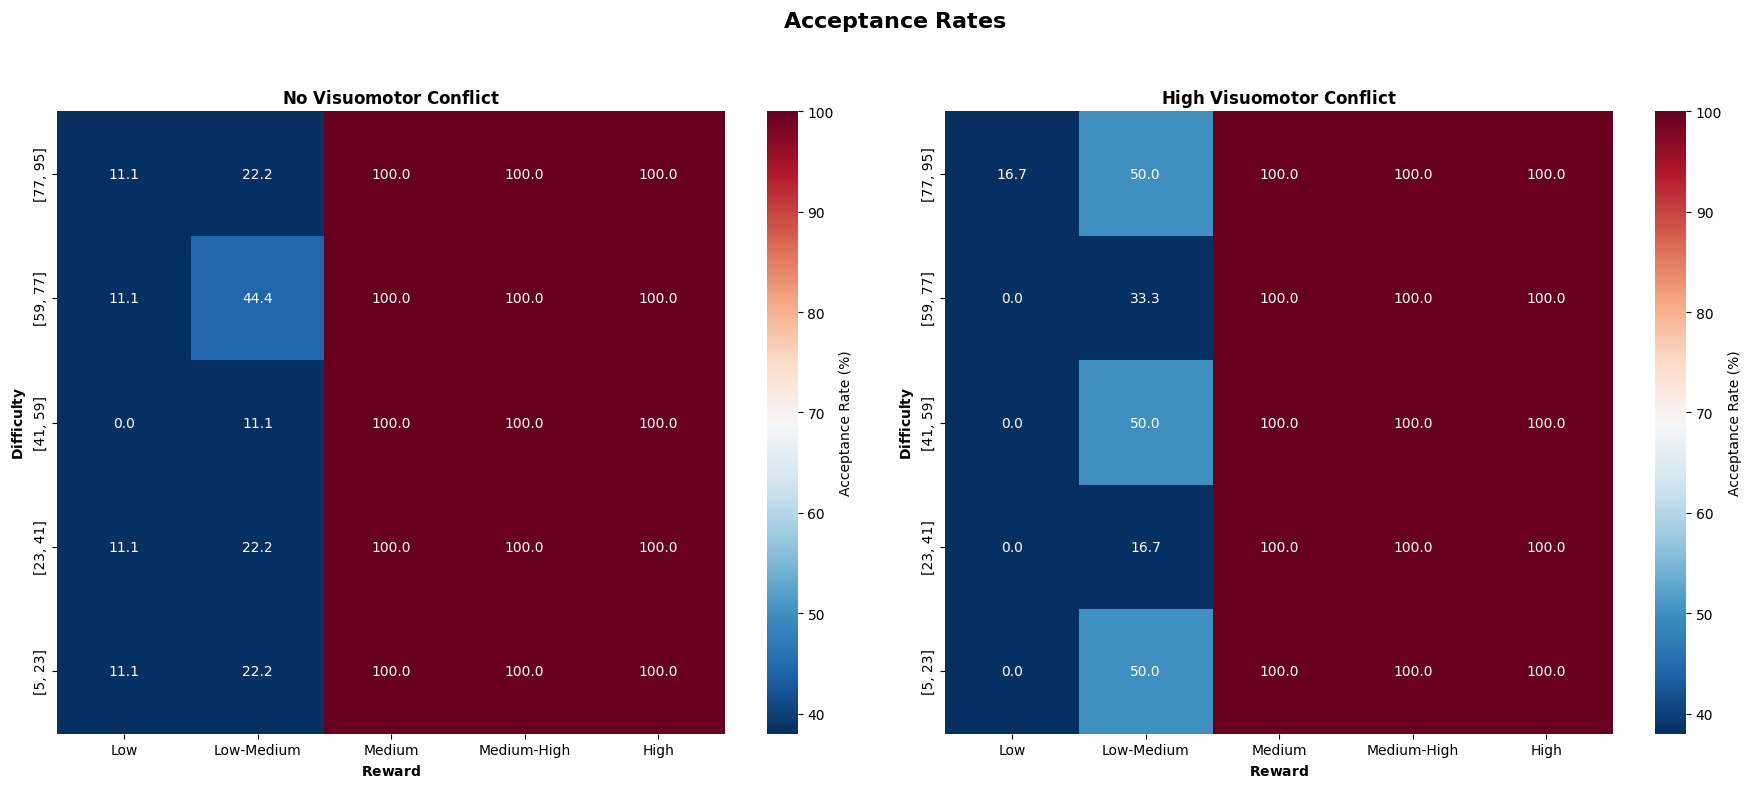

Comparing acceptance rate differences between Low Agency and High Agency:
Reward: High, Difficulty: High - Difference: 0.0000
Reward: High, Difficulty: Low - Difference: 0.0000


KeyError: 'Low-Medium'

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Directory where json files are stored
folder_path = 'C:/Users/ymijs/OneDrive/Documents/Internship/Data Analysis/EEG/Data/Behavioral-Tech-Test'

# Reward categories
LOW_REWARDS = [0.5, 1.5]
LOW_MEDIUM_REWARDS = [4.5, 5.5]
MEDIUM_REWARDS = [9.5, 10.5]
MEDIUM_HIGH_REWARDS = [19.5, 20.5]
HIGH_REWARDS = [39.5, 40.5]

def categorize_reward(reward):
    if LOW_REWARDS[0] <= reward <= LOW_REWARDS[1]:
        return 'Low'
    elif LOW_MEDIUM_REWARDS[0] <= reward <= LOW_MEDIUM_REWARDS[1]:
        return 'Low-Medium'
    elif MEDIUM_REWARDS[0] <= reward <= MEDIUM_REWARDS[1]:
        return 'Medium'
    elif MEDIUM_HIGH_REWARDS[0] <= reward <= MEDIUM_HIGH_REWARDS[1]:
        return 'Medium-High'
    elif HIGH_REWARDS[0] <= reward <= HIGH_REWARDS[1]:
        return 'High'
    else:
        return 'Other'

 
# Check if the data folder exists
if not os.path.exists(folder_path):
    print("Data folder does not exist.")
else:
    print(f"Accessing data folder: {folder_path}")

# Loop through all files in the data folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        print(f"Found file: {filename}")
        json_path = os.path.join(folder_path, filename)
        
        # Dictionary to hold combined data for each delay
        combined_data = {}
        
        with open(json_path, "r", encoding="utf-8") as json_file:
                data = json.load(json_file)
                # Convert JSON data into a DataFrame 
                df = pd.DataFrame(data)
                
                # Step 1: Filter for task = 'accept' - only processing these trials
                df_accept = df[df['task'] == 'accept'].copy()

                # Step 2: Group by unique delay values
                df_accept['delay'] = df_accept['delay'].apply(lambda x: str(x) if isinstance(x, list) else x)
                unique_delays = df_accept['delay'].unique()
                print(unique_delays)
                for delay in unique_delays:
                    # Step 3: Process each delay group independently
                    df_delay = df_accept[df_accept['delay'] == delay].copy()

                    # Directly use 'originalBounds' without converting to strings
                    df_delay['bounds_group'] = df_delay['originalBounds']
                    df_delay['bounds_group'] = df_delay['bounds_group'].apply(lambda x: str(x) if isinstance(x, list) else x)

                    # Categorize rewards based on values in the 'reward' column
                    df_delay['reward_group'] = df_delay['reward'].apply(categorize_reward)

                    # Filter directly for accepted trials (response == 'ArrowRight')
                    df_accepted = df_delay[df_delay['response'] == 'ArrowRight']

                    # Calculate total trials and accepted trials by reward and bounds group
                    total_trials = df_delay.groupby(['reward_group', 'bounds_group']).size().reset_index(name='total')
                    accepted_trials = df_accepted.groupby(['reward_group', 'bounds_group']).size().reset_index(name='accepted')

                    # Initialize or update the combined data for this delay
                    if delay not in combined_data:
                        combined_data[delay] = {'total': total_trials, 'accepted': accepted_trials}
                    else:
                        # Merge and sum the data with existing data for this delay
                        combined_data[delay]['total'] = combined_data[delay]['total'].merge(total_trials, on=['reward_group', 'bounds_group'], how='outer', suffixes=('', '_file'))
                        combined_data[delay]['accepted'] = combined_data[delay]['accepted'].merge(accepted_trials, on=['reward_group', 'bounds_group'], how='outer', suffixes=('', '_file'))

                        combined_data[delay]['total']['total'] = combined_data[delay]['total'][['total', 'total_file']].sum(axis=1)
                        combined_data[delay]['accepted']['accepted'] = combined_data[delay]['accepted'][['accepted', 'accepted_file']].sum(axis=1)

                        combined_data[delay]['total'].drop(columns=['total_file'], inplace=True)
                        combined_data[delay]['accepted'].drop(columns=['accepted_file'], inplace=True)

        # Create a grid of subplots
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Titles corresponding to delays
        plot_titles = {
            '[0, 0]': r"$\bf{No\ Visuomotor\ Conflict}$",
            '[0, 1000]': r"$\bf{High\ Visuomotor\ Conflict}$",
        }

        # Define color map and fixed color range for all heatmaps
        cmap = 'RdBu_r'
        vmin, vmax = 38, 100  # Fixed range for percentage acceptance rates

        # Iterate over the specified delays in the desired order
        for i, delay in enumerate(['[0, 0]','[0, 1000]']):
            if delay in combined_data:
                data = combined_data[delay]
                # Merge to calculate acceptance rate
                acceptance_rate = pd.merge(data['total'], data['accepted'], on=['reward_group', 'bounds_group'], how='left')
                acceptance_rate['accepted'] = acceptance_rate['accepted'].fillna(0)
                acceptance_rate['acceptance_rate'] = (acceptance_rate['accepted'] / acceptance_rate['total']) * 100  # Convert to percentage

                # Set categorical order for heatmap
                reward_order = ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']
                bounds_order = ['[77, 95]', '[59, 77]', '[41, 59]', '[23, 41]', '[5, 23]']
                acceptance_rate['reward_group'] = pd.Categorical(acceptance_rate['reward_group'], categories=reward_order, ordered=True)
                acceptance_rate['bounds_group'] = pd.Categorical(acceptance_rate['bounds_group'], categories=bounds_order, ordered=True)

                # Generate the heatmap for this delay
                print(acceptance_rate)
                heatmap_data = acceptance_rate.pivot(index='bounds_group', columns='reward_group', values='acceptance_rate')

                if not heatmap_data.empty and heatmap_data.notna().any().any():
                    sns.heatmap(
                        heatmap_data, 
                        annot=True, 
                        cmap=cmap, 
                        cbar_kws={'label': 'Acceptance Rate (%)'}, 
                        ax=axes[i], 
                        vmin=vmin, 
                        vmax=vmax, 
                        fmt=".1f"  # Format numbers with one decimal place
                    )
                    axes[i].set_title(plot_titles[delay])
                    axes[i].set_xlabel(r"$\bf{Reward}$")
                    axes[i].set_ylabel(r"$\bf{Difficulty}$")
                else:
                    print(f"No valid data to plot for delay: {delay} in combined data.")

        # Set the super title for the whole figure
        plt.suptitle(r"$\bf{Acceptance\ Rates}$", fontsize=16)

        # Adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # The rect parameter adjusts the space for the super title

        # Show the combined plot
        plt.show()

        # Update bounds mapping to corresponding labels
        bounds_mapping = {
         '[5, 23]': 'Low',
         '[23, 41]': 'LowMedium',
         '[41, 59]': 'Medium',
         '[59, 77]': 'MediumHigh',
         '[77, 95]': 'High',
        }

        # Replace the numeric bounds with the corresponding labels in your combined data
        for delay in combined_data.keys():
            combined_data[delay]['total']['bounds_group'] = combined_data[delay]['total']['bounds_group'].map(bounds_mapping)
            combined_data[delay]['accepted']['bounds_group'] = combined_data[delay]['accepted']['bounds_group'].map(bounds_mapping)

        # Function to compare and print all differences between two acceptance rate heatmaps
        def compare_and_print_all_differences(rate_map1, rate_map2, delay1, delay2):
            # Calculate the absolute differences between the two acceptance rate heatmaps
            difference = rate_map1.subtract(rate_map2).abs()
            
            # Print all differences
            print(f"Comparing acceptance rate differences between {delay1} and {delay2}:")
            for idx in difference.stack().index:
                reward_group, bounds_group = idx
                diff_value = difference.at[bounds_group, reward_group]
                print(f"Reward: {reward_group}, Difficulty: {bounds_group} - Difference: {diff_value:.4f}")
            print()

        # Generate the acceptance rate heatmaps for each delay using labels
        heatmap_low = combined_data['[0, 1000]']['total'].merge(
            combined_data['[0, 1000]']['accepted'], on=['reward_group', 'bounds_group'], suffixes=('_total', '_accepted')
        )
        heatmap_low['acceptance_rate'] = (heatmap_low['accepted'] / heatmap_low['total'])*100
        heatmap_low = heatmap_low.pivot(index='bounds_group', columns='reward_group', values='acceptance_rate')

        heatmap_high = combined_data['[0, 0]']['total'].merge(
            combined_data['[0, 0]']['accepted'], on=['reward_group', 'bounds_group'], suffixes=('_total', '_accepted')
        )
        heatmap_high['acceptance_rate'] = (heatmap_high['accepted'] / heatmap_high['total'])*100
        heatmap_high = heatmap_high.pivot(index='bounds_group', columns='reward_group', values='acceptance_rate')

        # Compare Low vs High
        compare_and_print_all_differences(heatmap_low, heatmap_high, 'Low Agency', 'High Agency')






2. Acceptance rate throughout the experience :

Accessing data folder: /Users/marr/Documents/EPFL/Projet_bach/participants_data
Processing file: data_P01.json


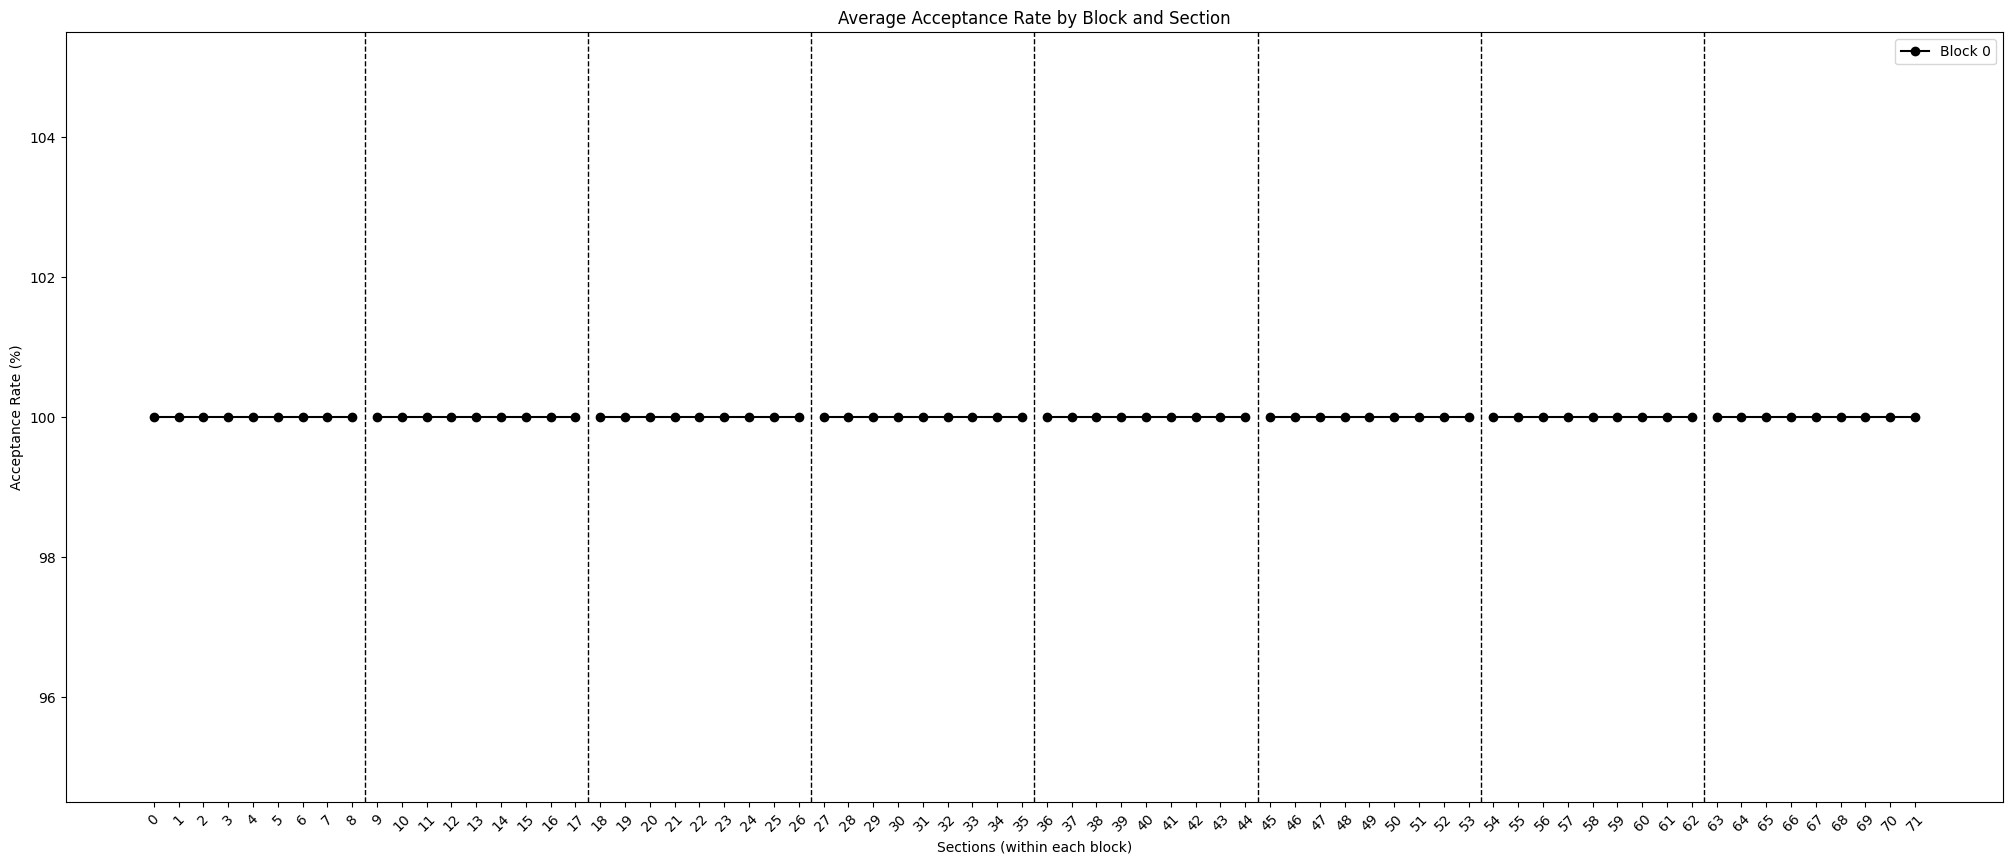

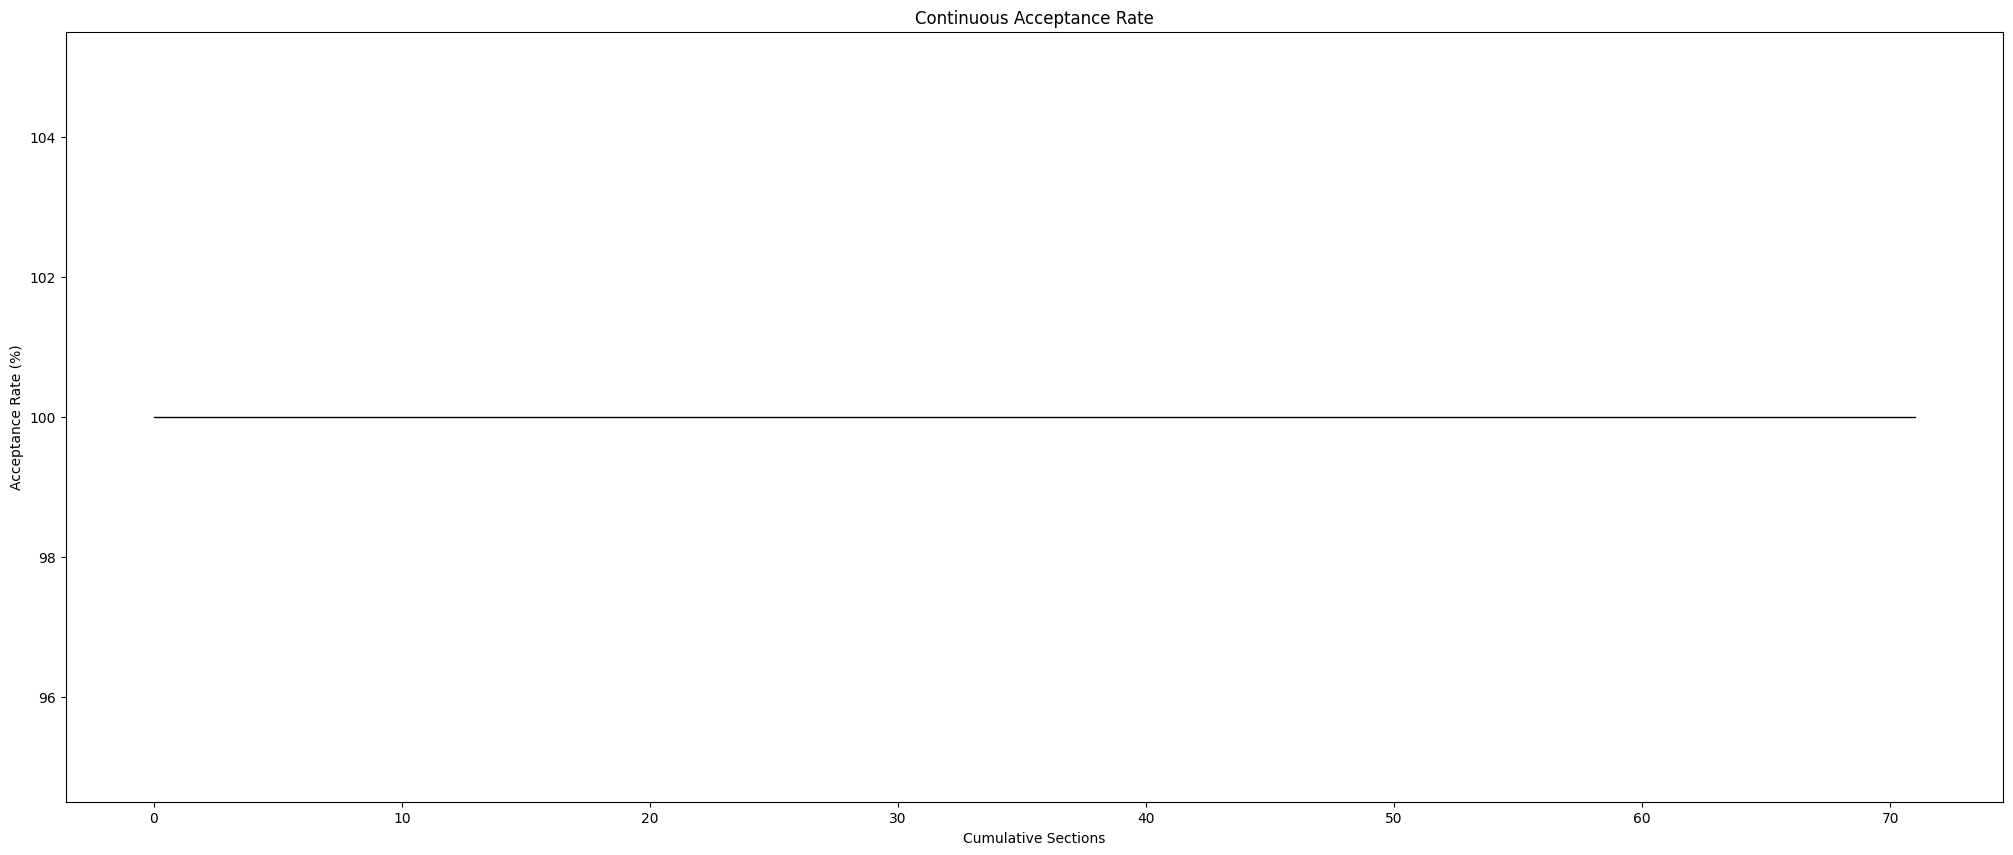

Processing file: data_P05.json


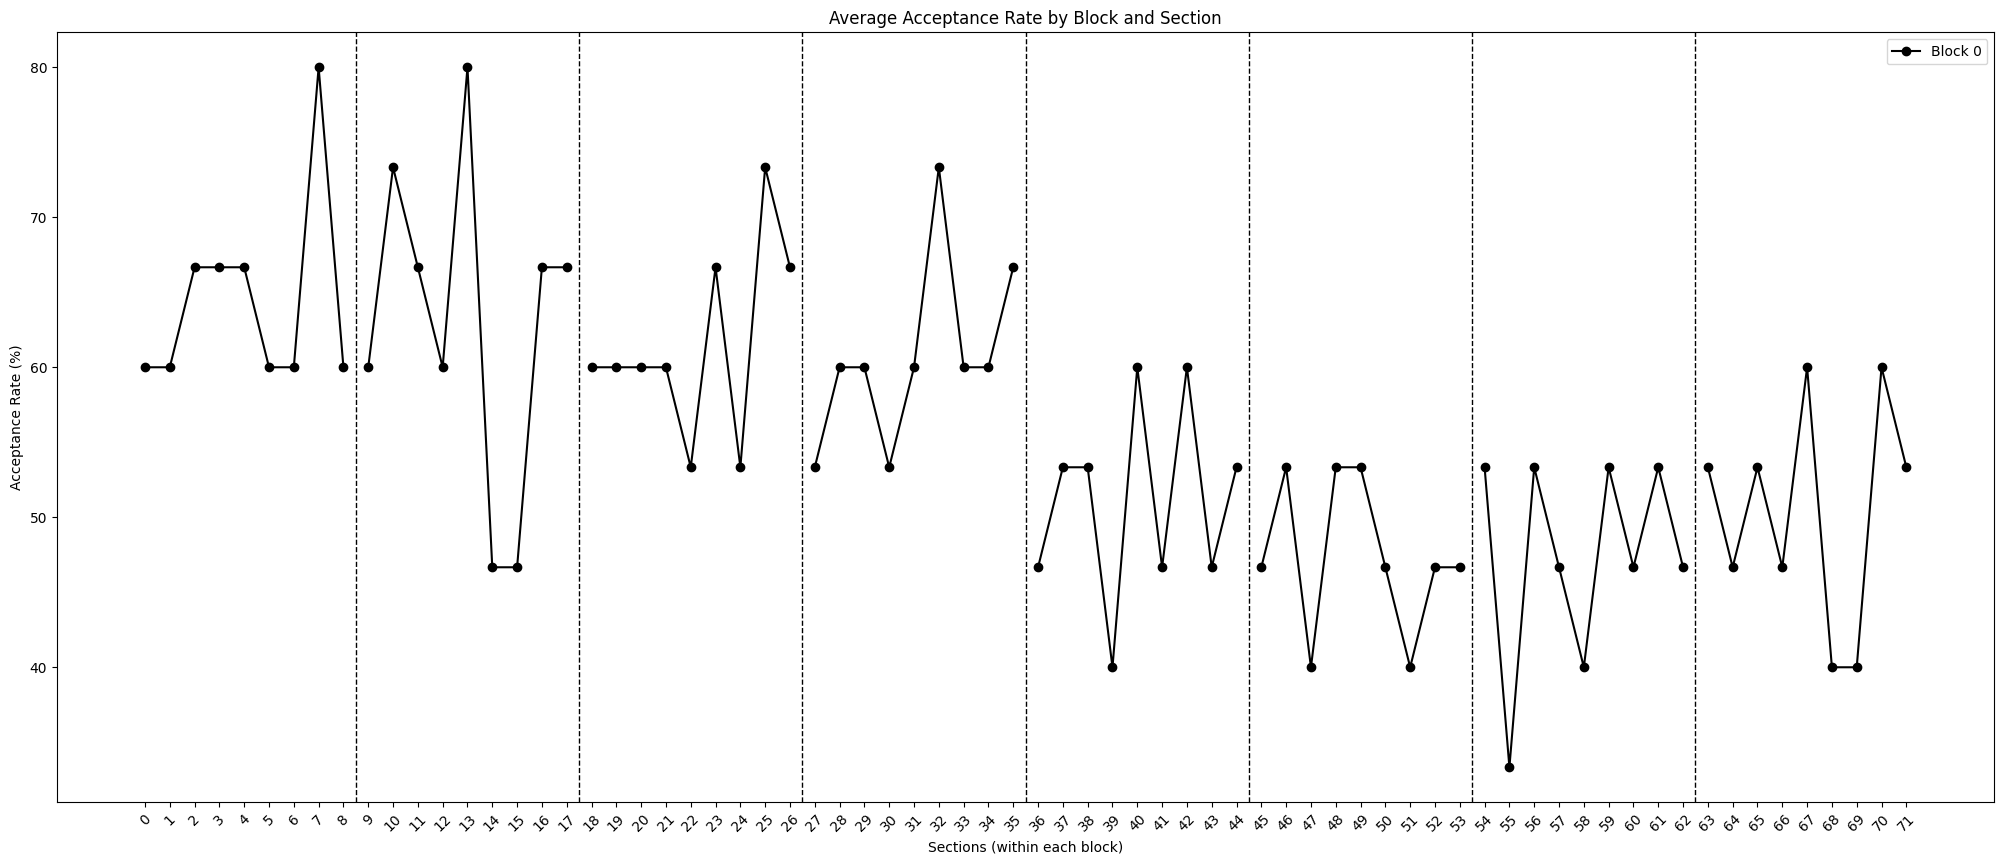

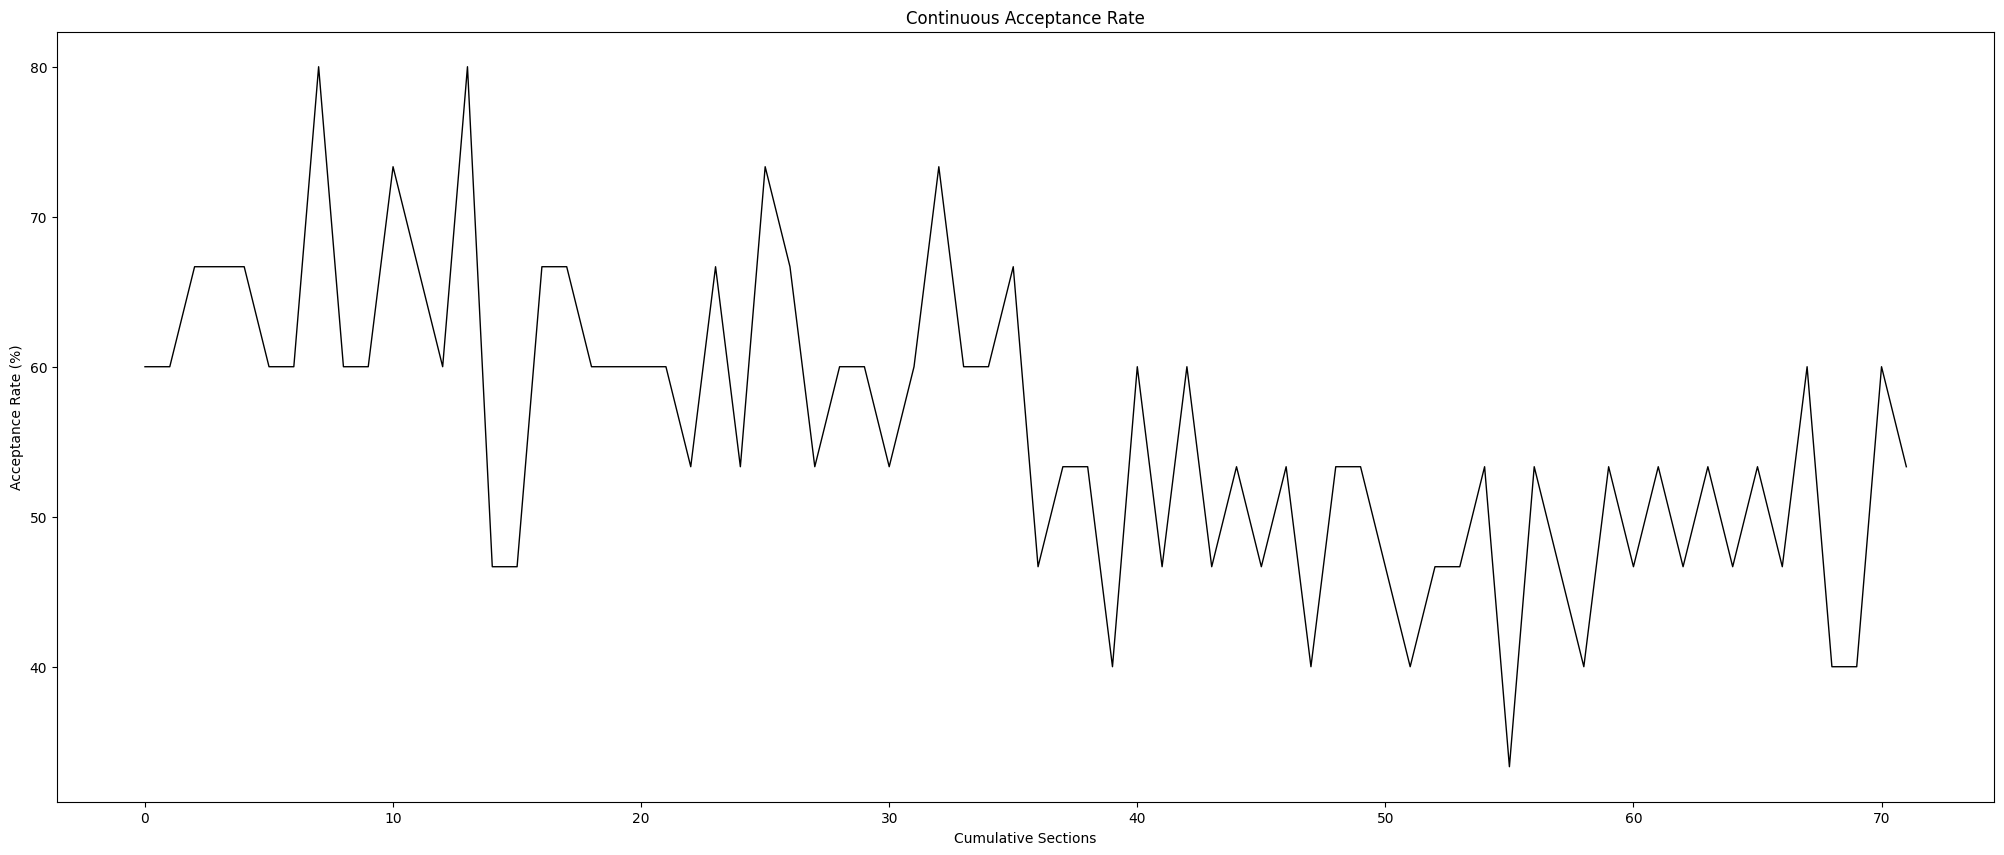

Processing file: data_P04.json


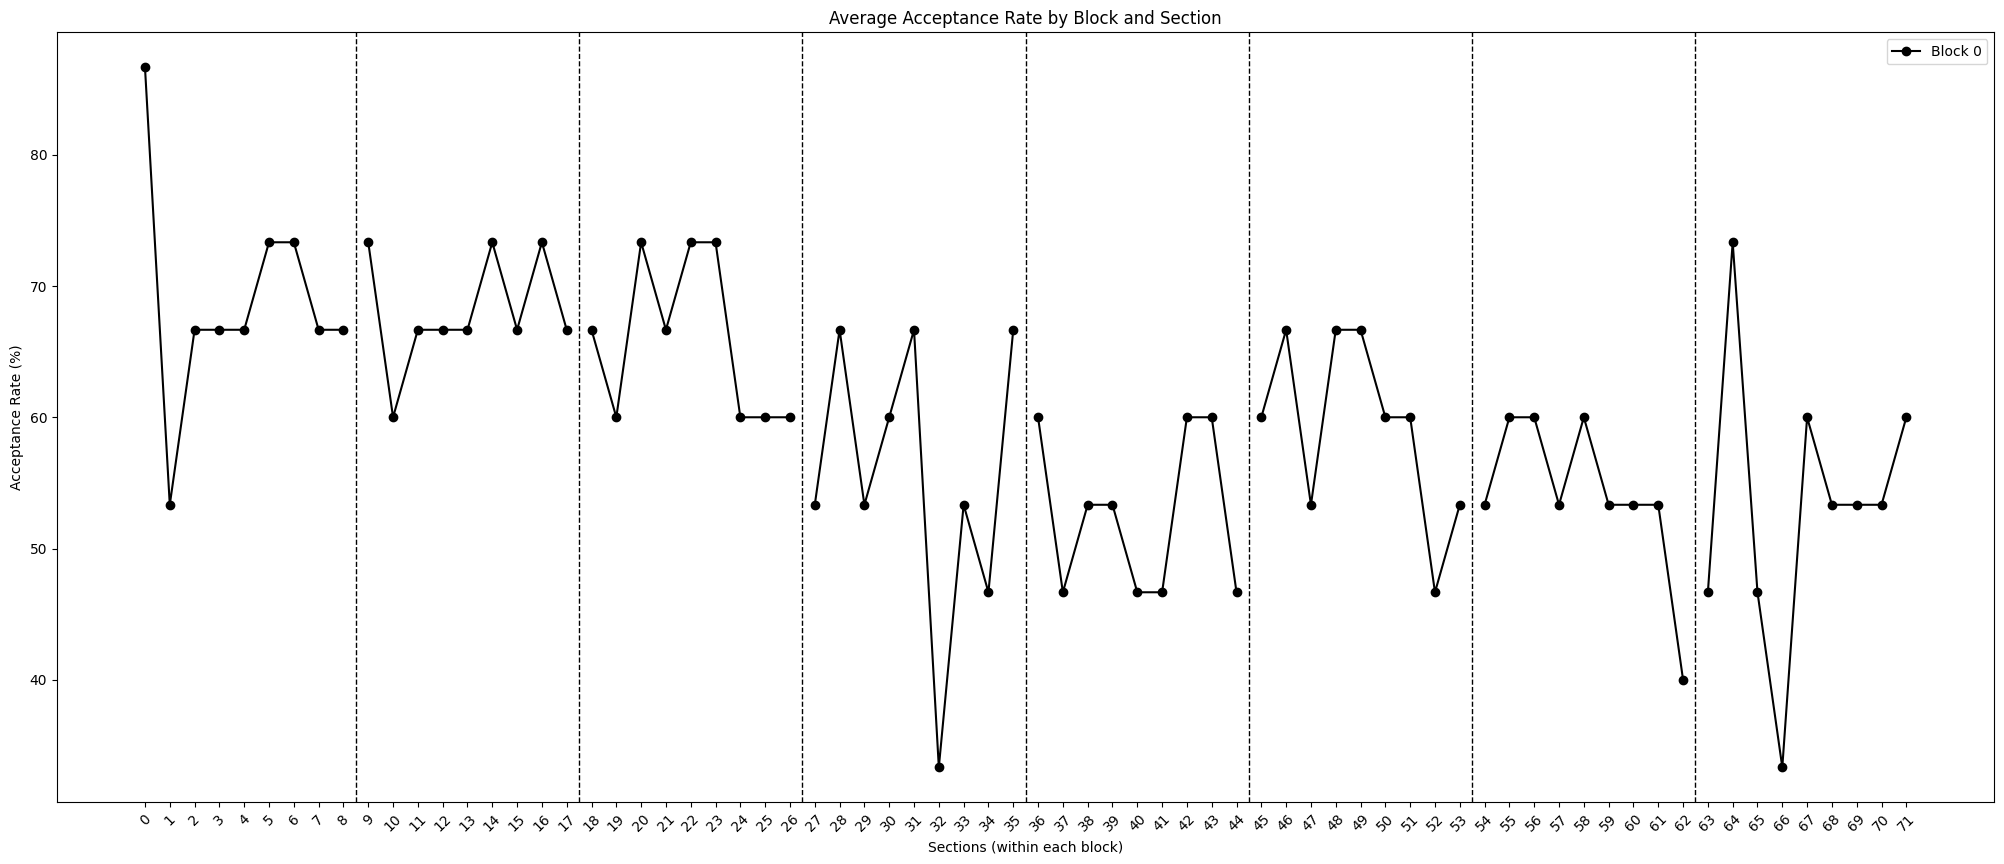

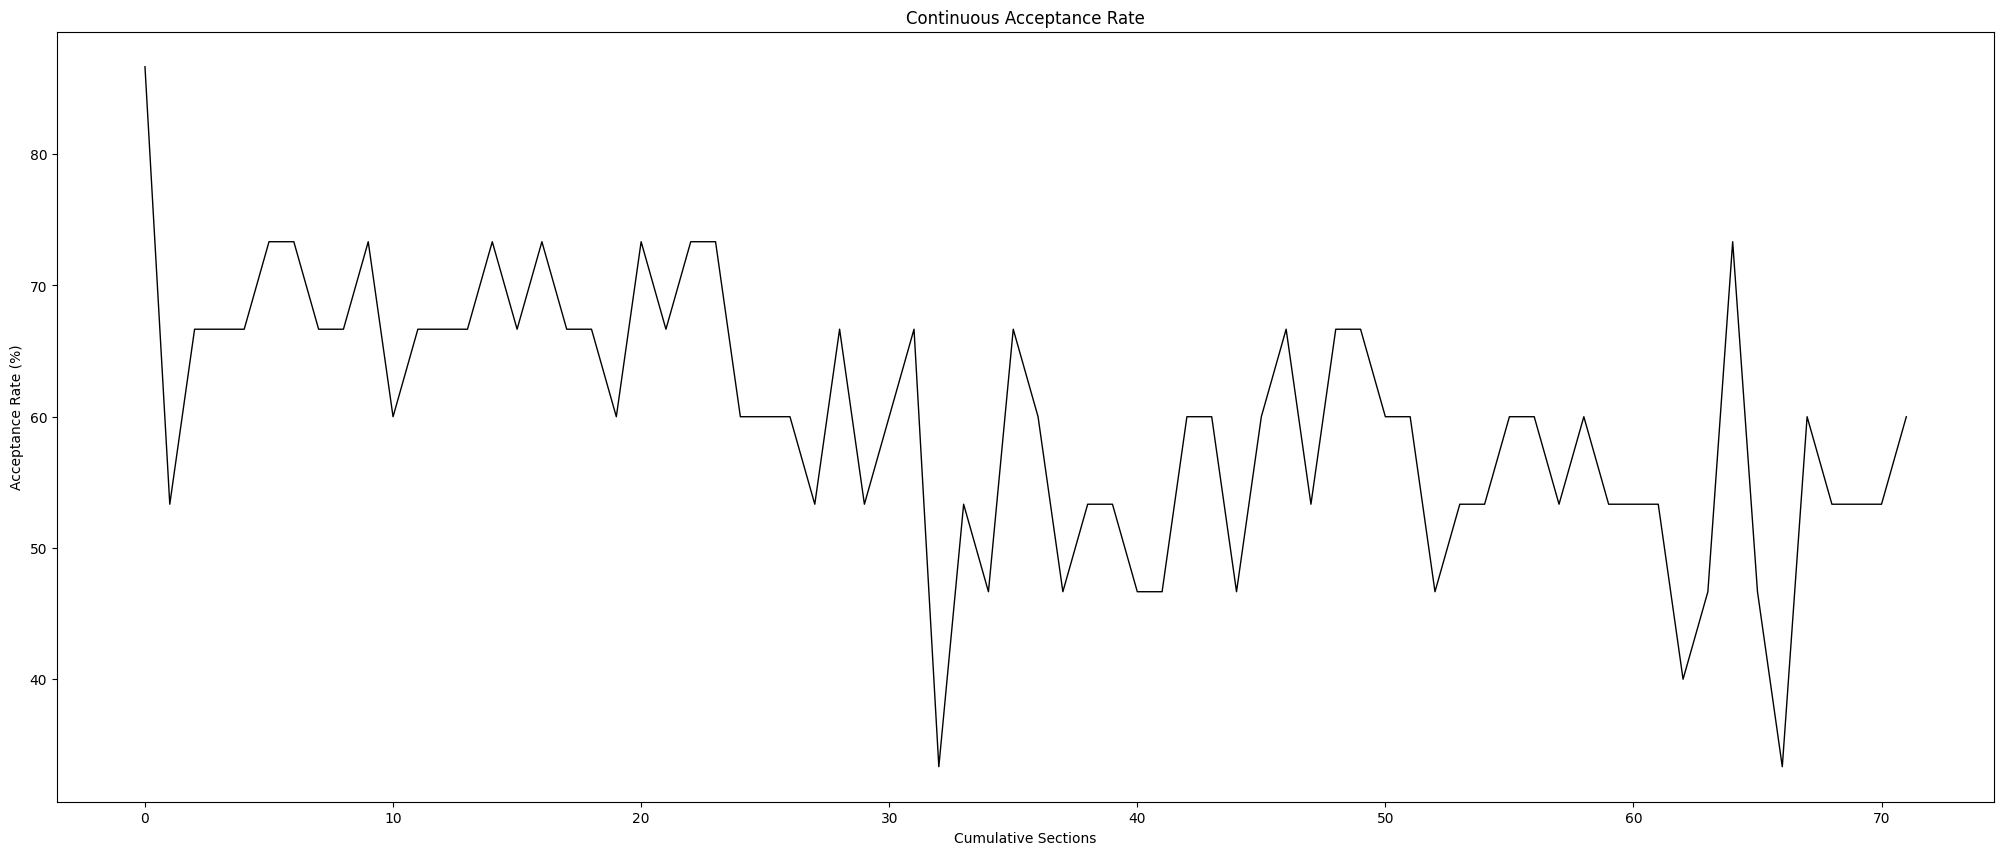

Processing file: data_P03.json


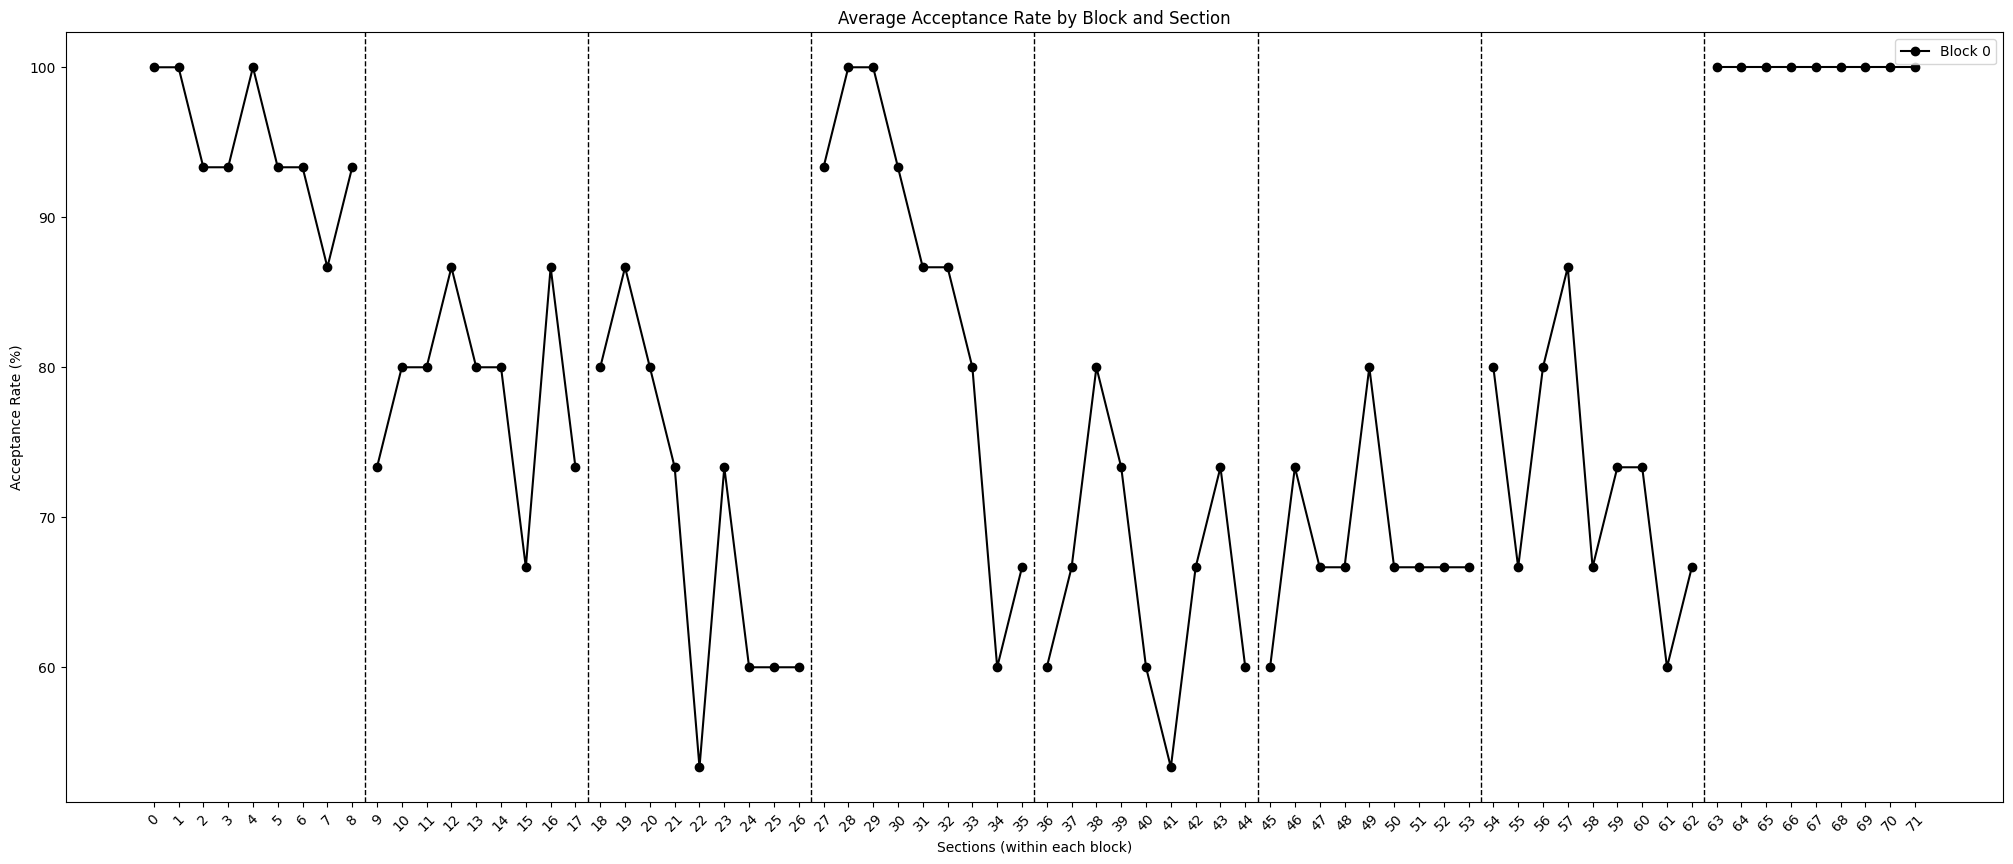

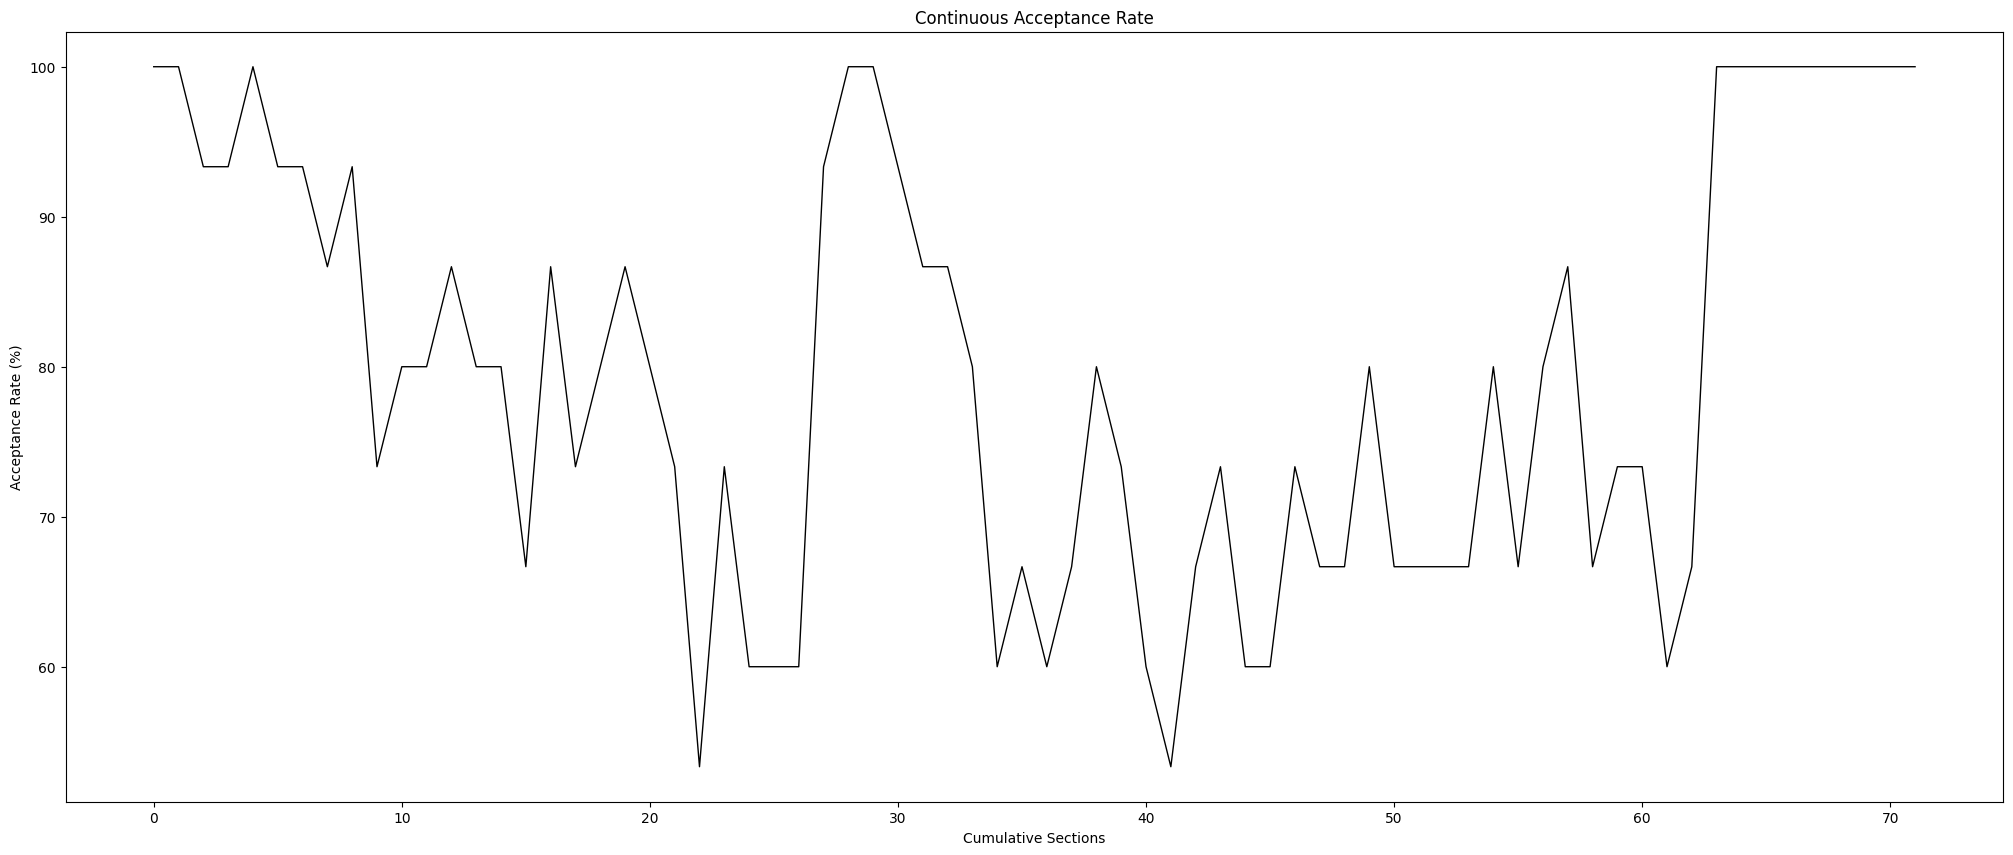

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# Directory where CSV files are stored
folder_path = os.path.expanduser('~/Documents/EPFL/Projet_bach/participants_data')

# Check if the data folder exists
if not os.path.exists(folder_path):
    print("Data folder does not exist.")
    exit()
else:
    print(f"Accessing data folder: {folder_path}")

# Process each JSON file
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        print(f"Processing file: {filename}")
        json_path = os.path.join(folder_path, filename)

        # Read JSON into DataFrame
        with open(json_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data)

        # Step 1: Filter for accepted trials
        df_accept = df[df['accepted'].notna()].copy()
        num_rows = len(df_accept)
        
        if num_rows == 0:
            print(f"Skipping {filename}, no valid 'accepted' data.")
            continue

        block_size = num_rows // 8  # Divide into 8 blocks

        # Step 2: Create 8 ordered blocks
        blocks = [
            df_accept.iloc[i * block_size: (i + 1) * block_size] for i in range(7)
        ] + [df_accept.iloc[7 * block_size:]]  # Last block includes remainder

        results = []
        for block_index, block_data in enumerate(blocks):
            for section_index in range(9):
                section_data = block_data.iloc[section_index * 15:(section_index + 1) * 15]
                if len(section_data) == 0:
                    continue
                acceptance_rate = section_data['accepted'].sum() / len(section_data) * 100
                results.append({
                    'block_index': block_index,
                    'section_index': section_index,
                    'acceptance %': acceptance_rate
                })

        result_df = pd.DataFrame(results)
        if result_df.empty:
            print(f"Skipping {filename}, no valid sections found.")
            continue

        # Step 3: Compute mean acceptance % by block and section
        average_acceptance_df = result_df.groupby(['block_index', 'section_index'], as_index=False)['acceptance %'].mean()

        # Figures
        plt.figure(figsize=(25, 10))

        # Plot each block separately
        for block_index in sorted(average_acceptance_df['block_index'].unique()):
            block_data = average_acceptance_df[average_acceptance_df['block_index'] == block_index]
            x_positions = [block_index * 9 + section for section in block_data['section_index']]
            plt.plot(x_positions, block_data['acceptance %'], marker='o', color='black', label=f'Block {block_index}' if block_index == 0 else "")

        # Add vertical lines to separate blocks
        for block_index in range(1, average_acceptance_df['block_index'].max() + 1):
            plt.axvline(x=block_index * 9 - 0.5, color='black', linestyle='--', linewidth=1)

        plt.title(f'Average Acceptance Rate by Block and Section')
        plt.xlabel('Sections (within each block)')
        plt.ylabel('Acceptance Rate (%)')
        plt.xticks(range(0, 9 * (average_acceptance_df['block_index'].max() + 1)), rotation=45)
        plt.legend()
        
        # Use non-blocking display
        plt.pause(0.01)
        plt.close() 

        # Continuous plot 
        plt.figure(figsize=(25, 10))
        average_acceptance_df['x_position'] = average_acceptance_df['block_index'] * 9 + average_acceptance_df['section_index']
        plt.plot(
            average_acceptance_df['x_position'],
            average_acceptance_df['acceptance %'],
            color='black',
            linestyle='-',
            linewidth=1
        )
        plt.title(f'Continuous Acceptance Rate')
        plt.xlabel('Cumulative Sections')
        plt.ylabel('Acceptance Rate (%)')
        
        plt.pause(0.01)
        plt.close()  


Codes combined

Accessing data folder: /Users/marr/Documents/EPFL/Projet_bach/participants_data
Found file: data_P01.json
Processing file: /Users/marr/Documents/EPFL/Projet_bach/participants_data/data_P01.json.csv
Acceptance rate for each combinations: 


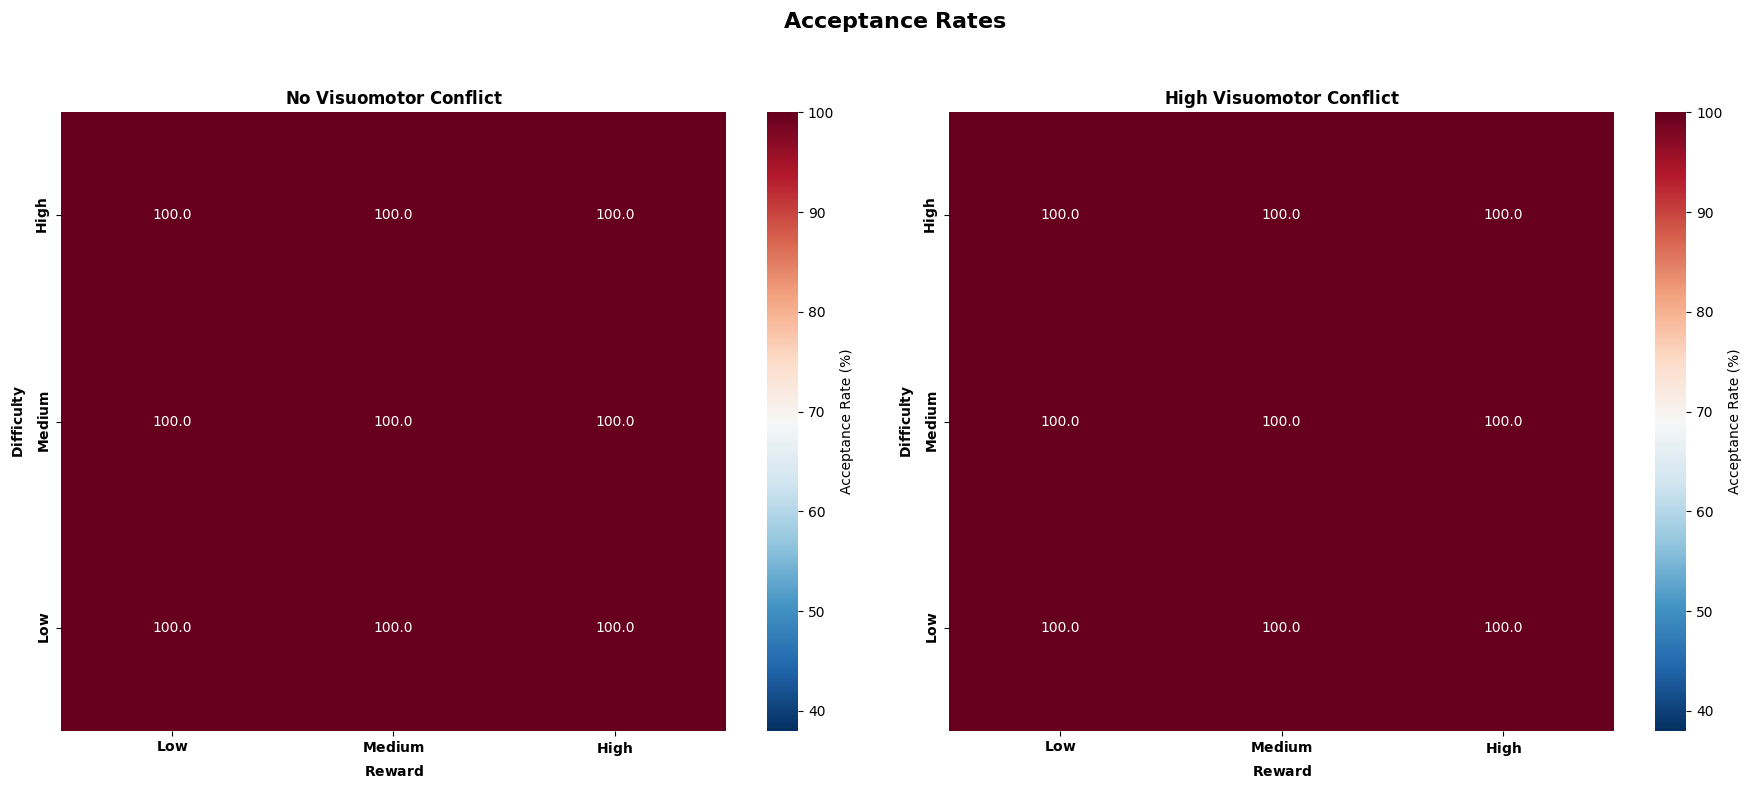

Comparing acceptance rate differences between Low Agency and High Agency:
Reward: High, Difficulty: High - Difference: 0.0000
Reward: High, Difficulty: Low - Difference: 0.0000
Reward: High, Difficulty: Medium - Difference: 0.0000
Reward: Low, Difficulty: High - Difference: 0.0000
Reward: Low, Difficulty: Low - Difference: 0.0000
Reward: Low, Difficulty: Medium - Difference: 0.0000
Reward: Medium, Difficulty: High - Difference: 0.0000
Reward: Medium, Difficulty: Low - Difference: 0.0000
Reward: Medium, Difficulty: Medium - Difference: 0.0000

Acceptance rate throughout the experience : 


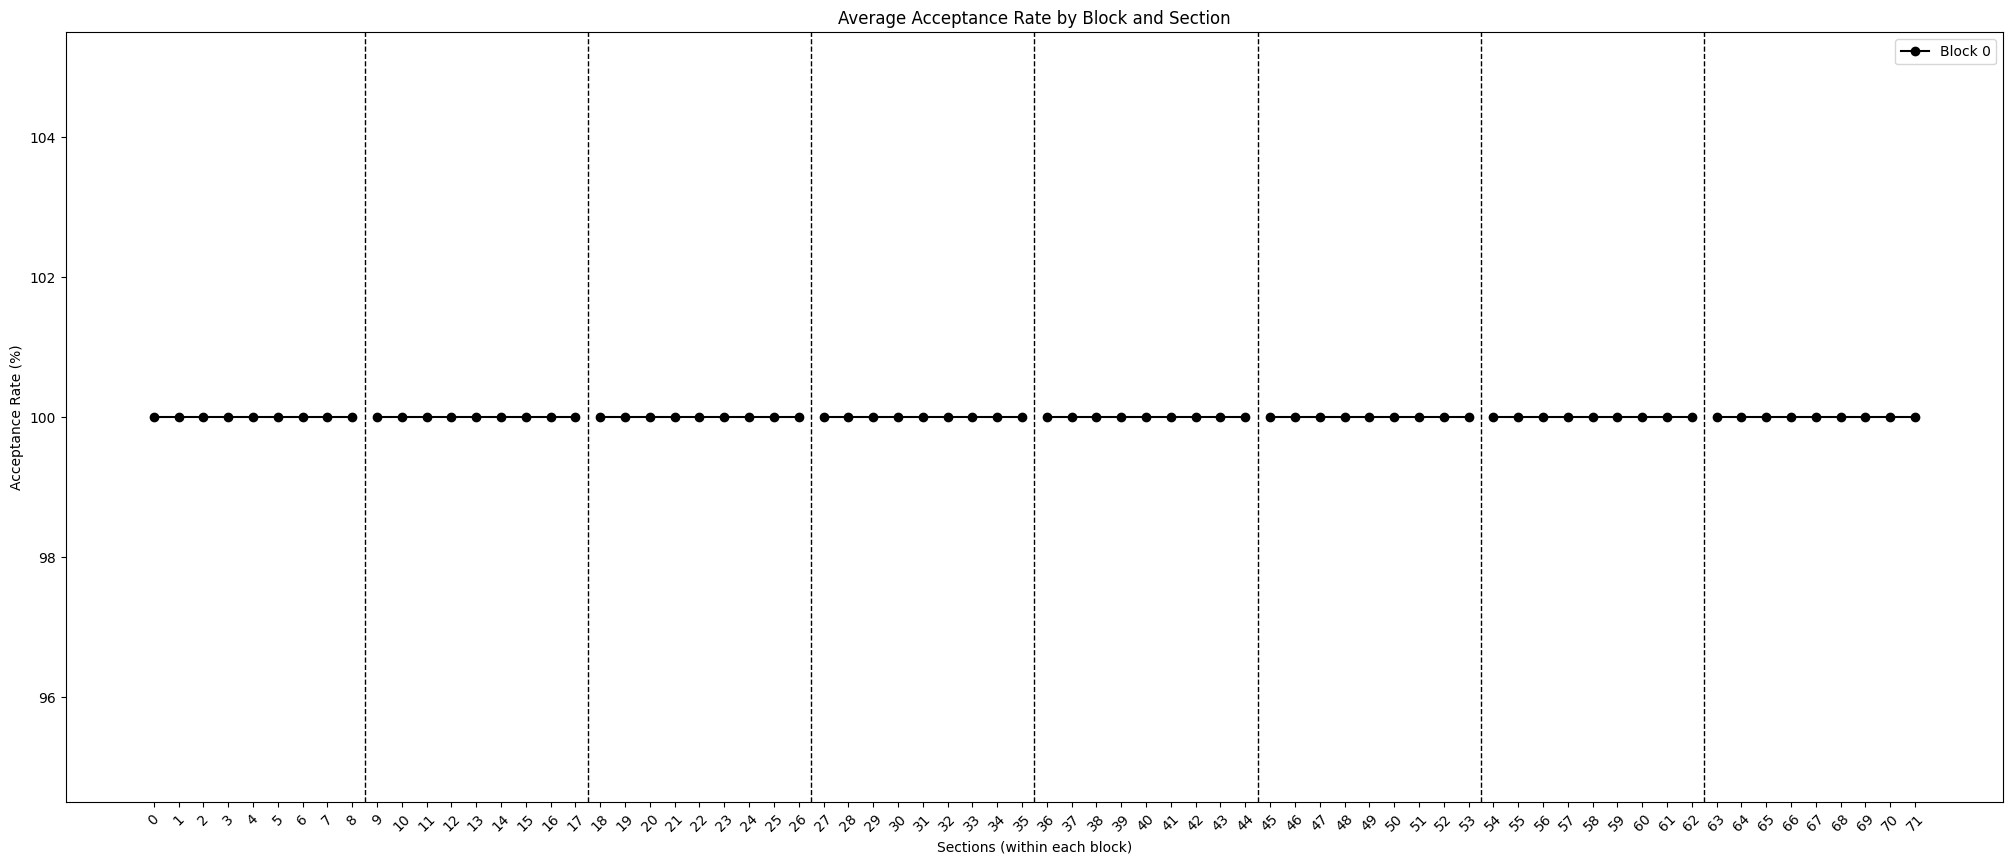

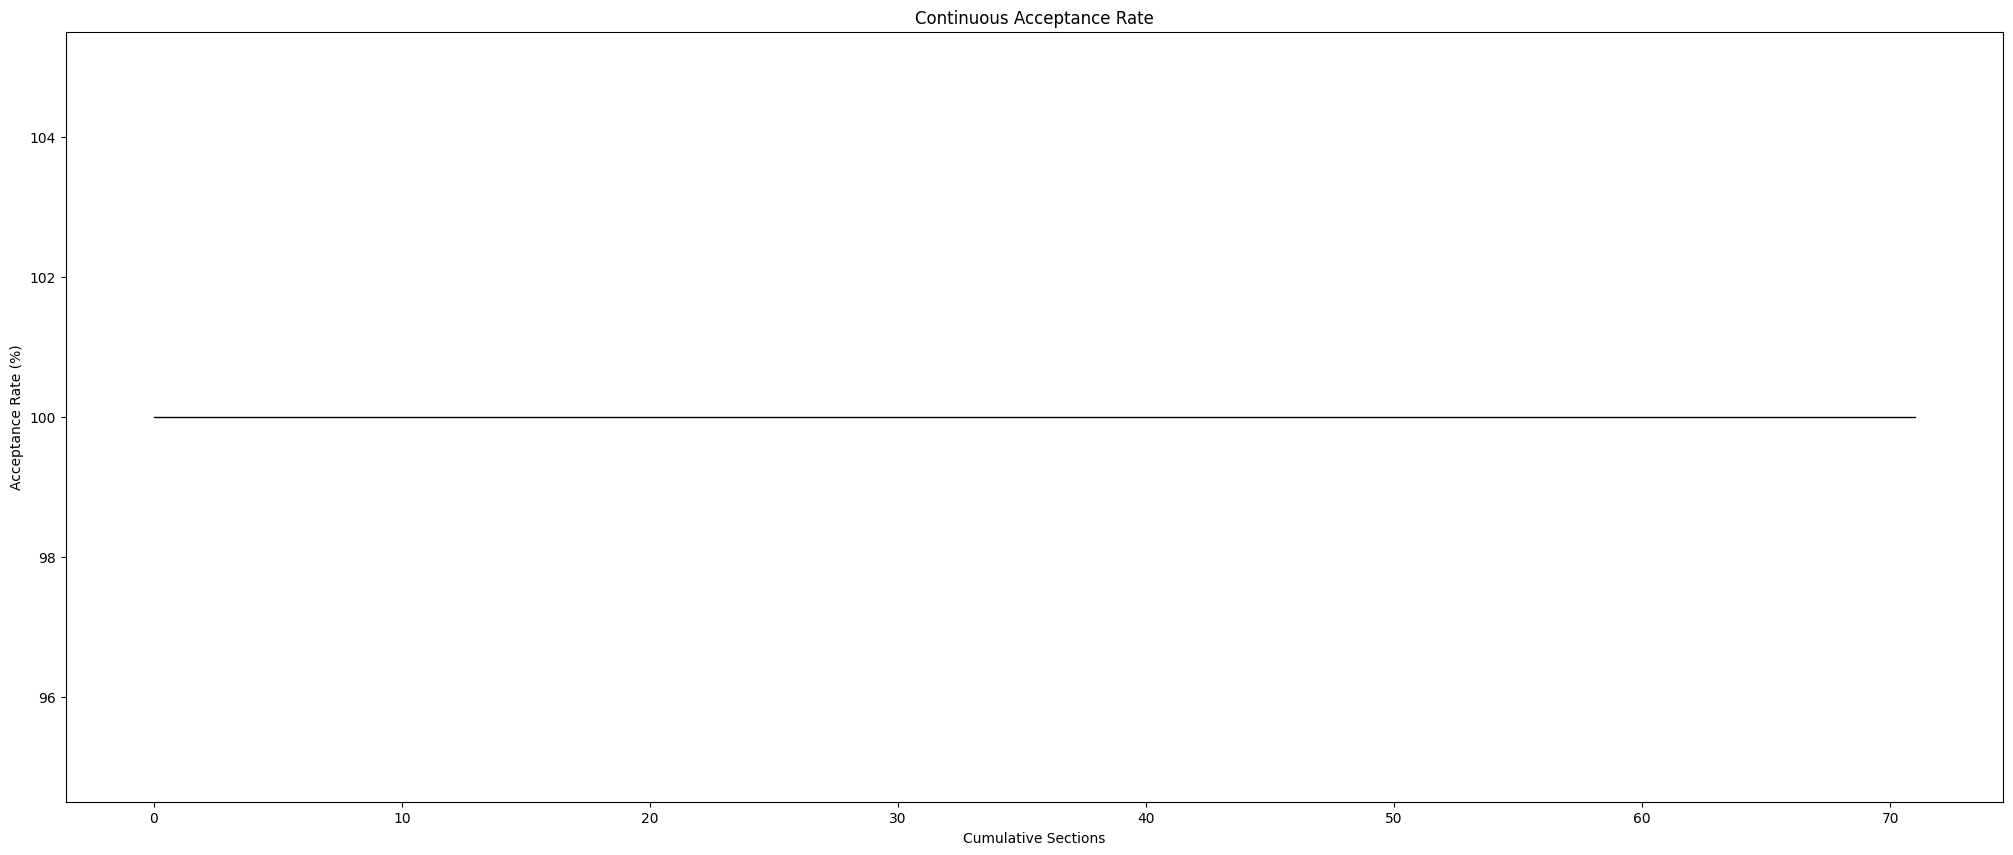

Found file: data_P05.json
Processing file: /Users/marr/Documents/EPFL/Projet_bach/participants_data/data_P05.json.csv
Acceptance rate for each combinations: 


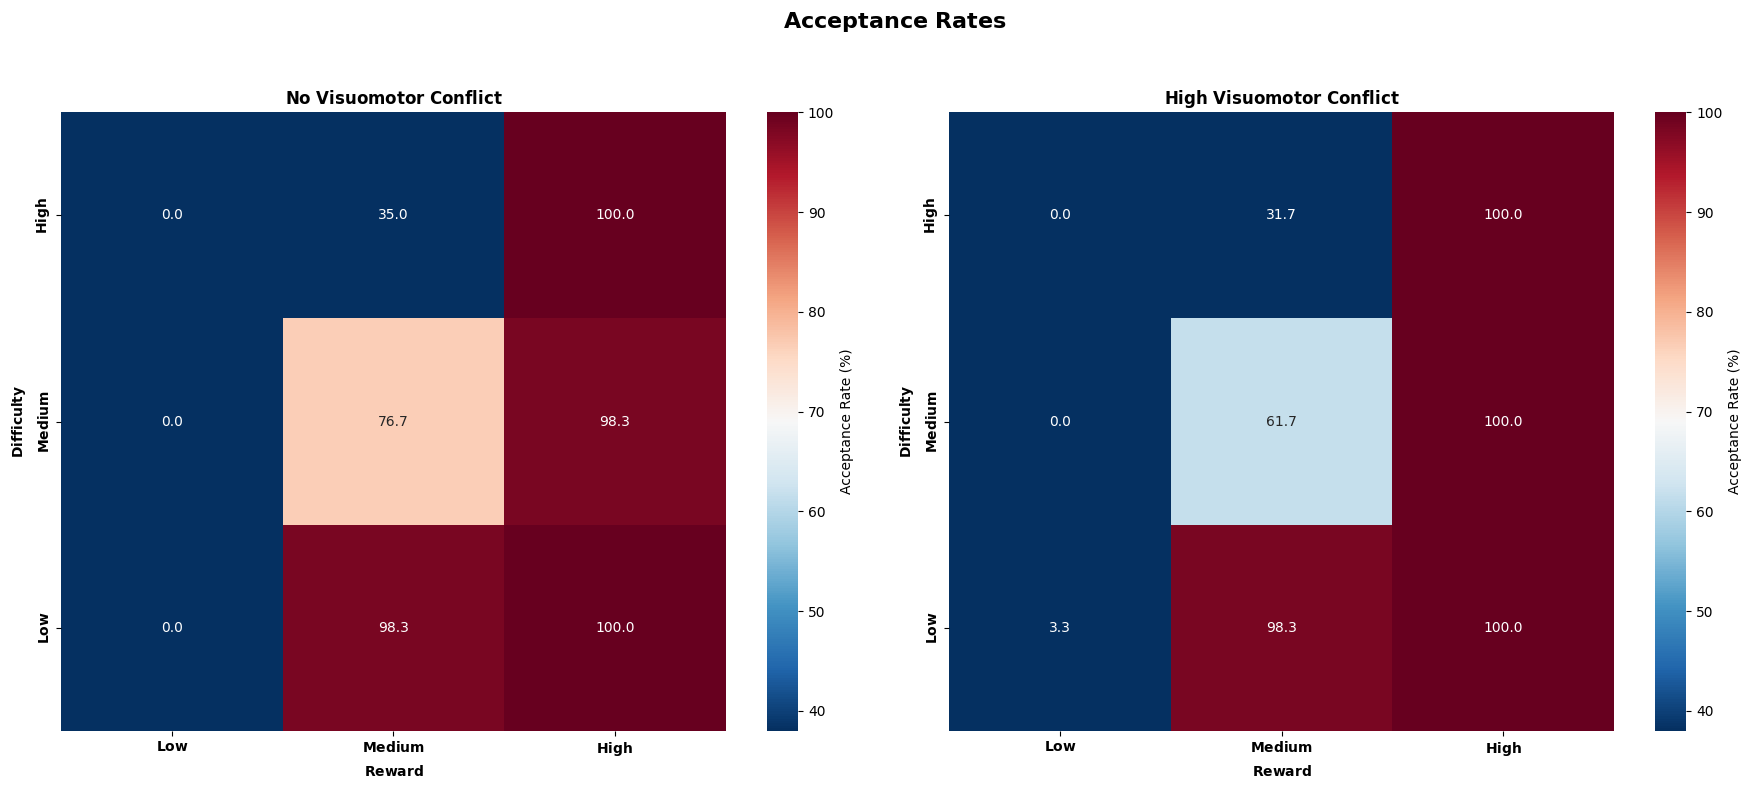

Comparing acceptance rate differences between Low Agency and High Agency:
Reward: High, Difficulty: High - Difference: 0.0000
Reward: High, Difficulty: Medium - Difference: 1.6667
Reward: Low, Difficulty: High - Difference: nan
Reward: Low, Difficulty: Medium - Difference: nan
Reward: Medium, Difficulty: High - Difference: 3.3333
Reward: Medium, Difficulty: Medium - Difference: 15.0000

Acceptance rate throughout the experience : 


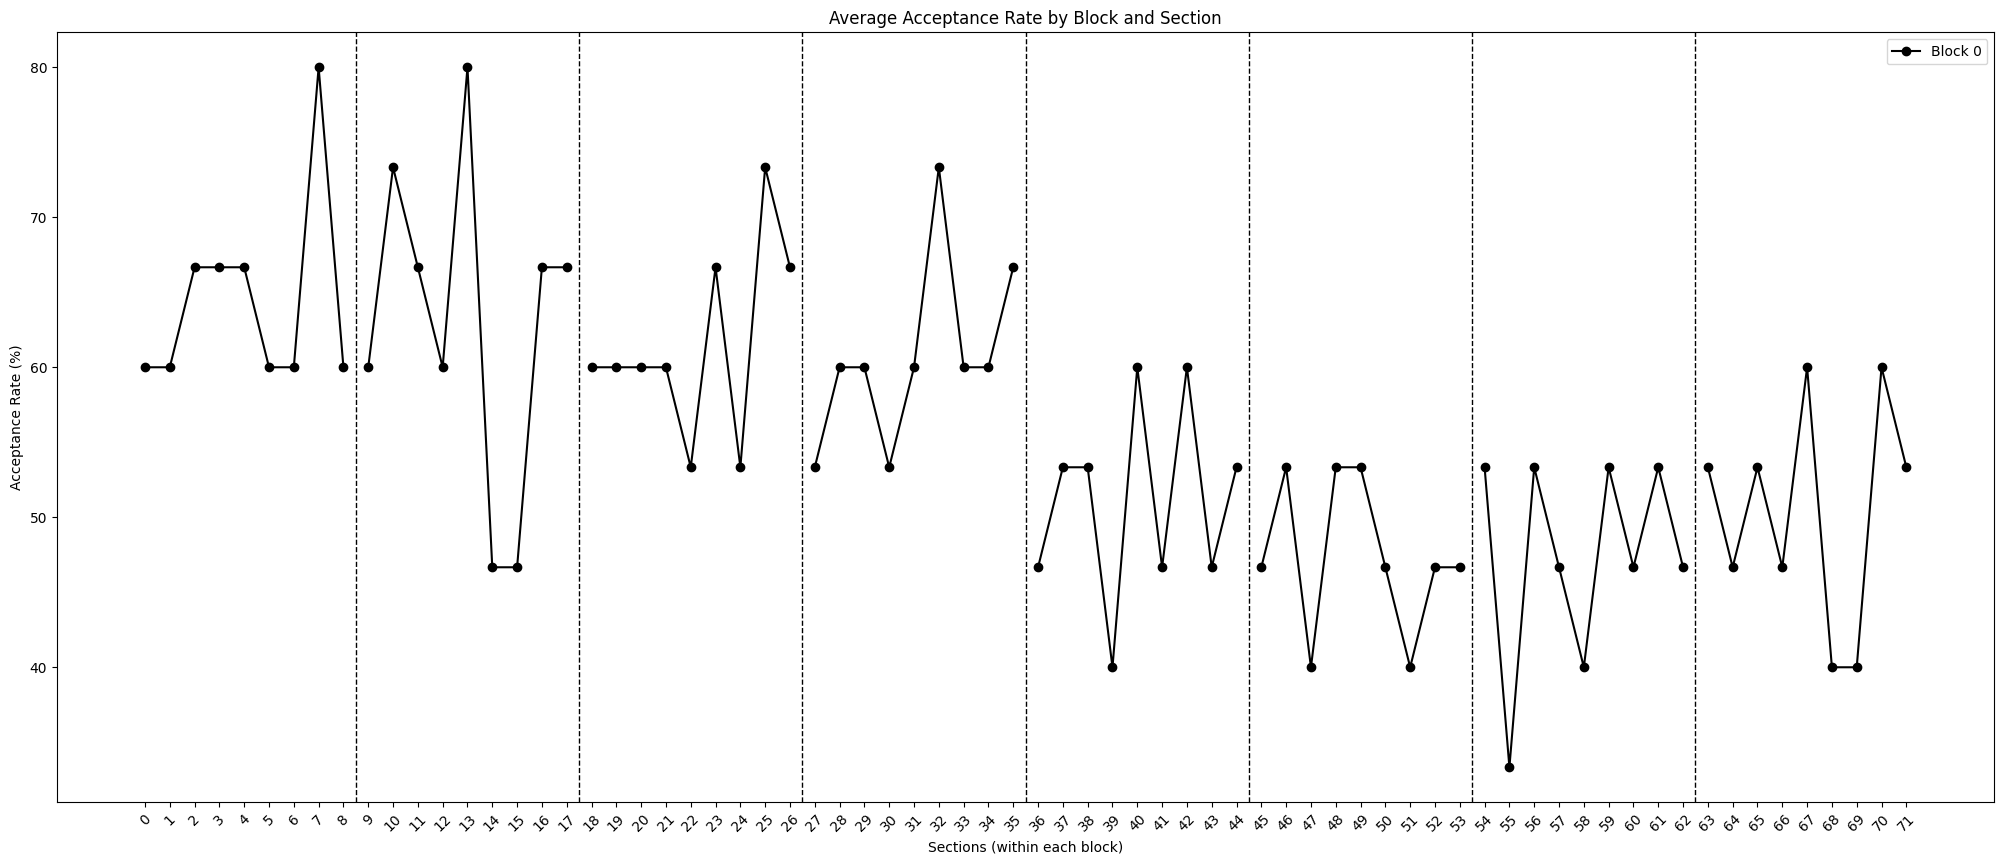

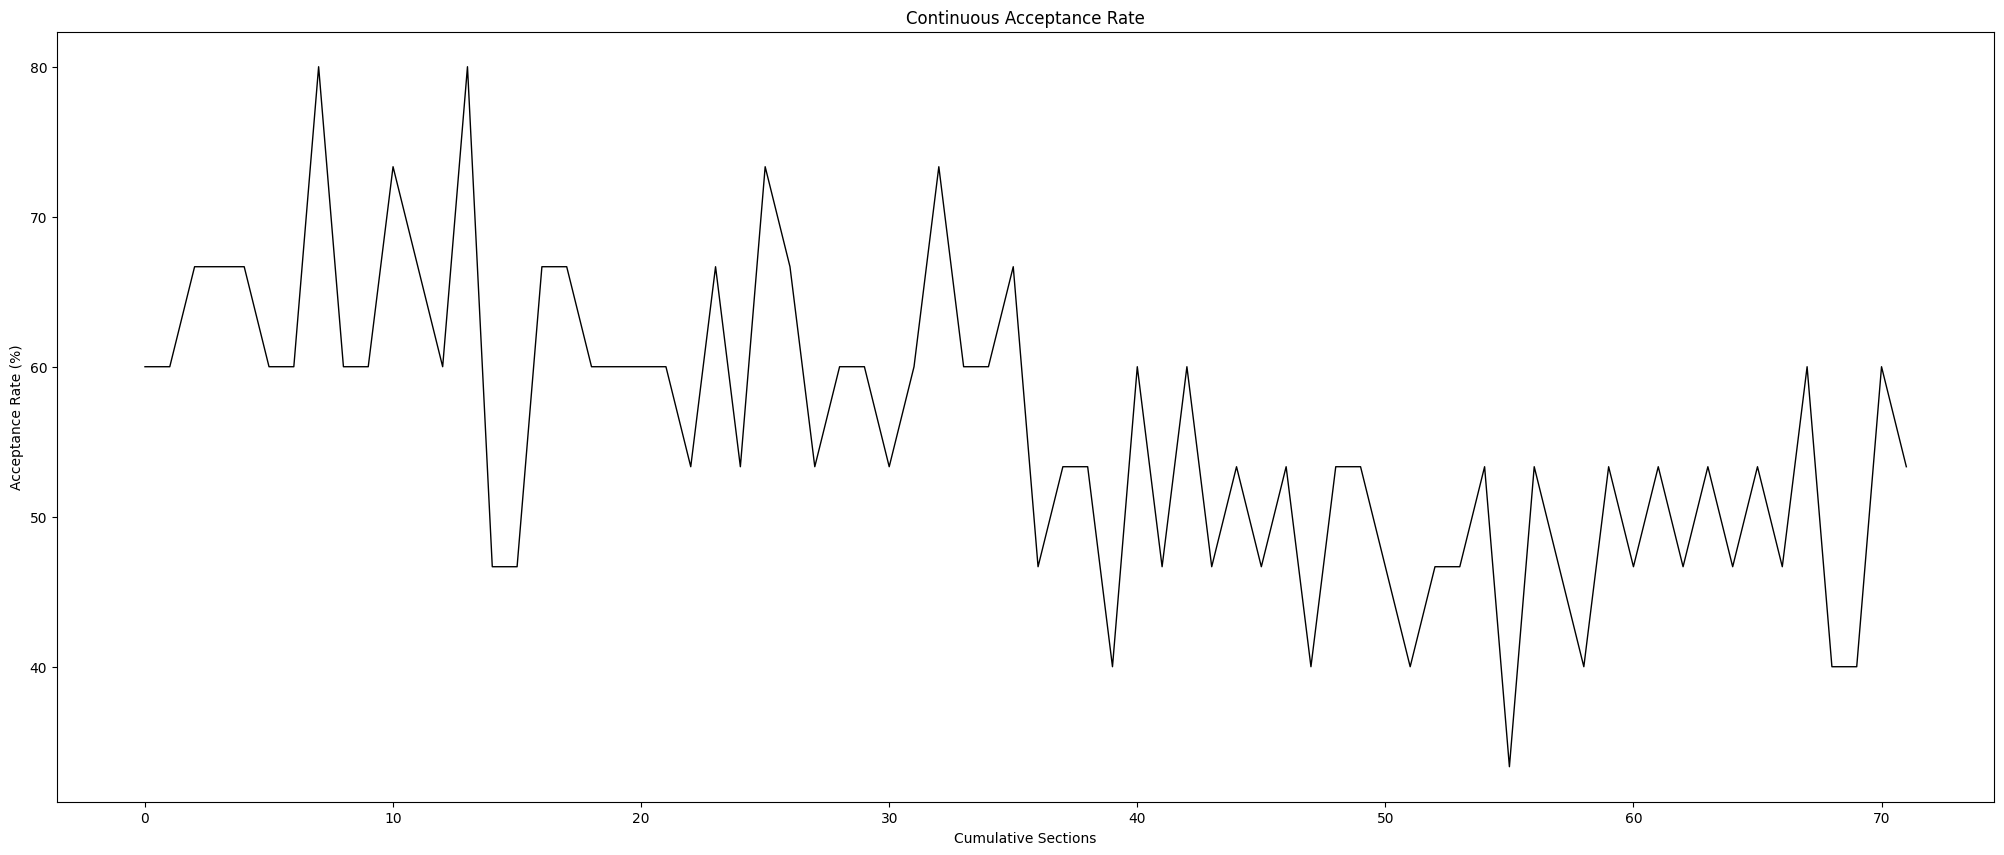

Found file: data_P04.json
Processing file: /Users/marr/Documents/EPFL/Projet_bach/participants_data/data_P04.json.csv
Acceptance rate for each combinations: 


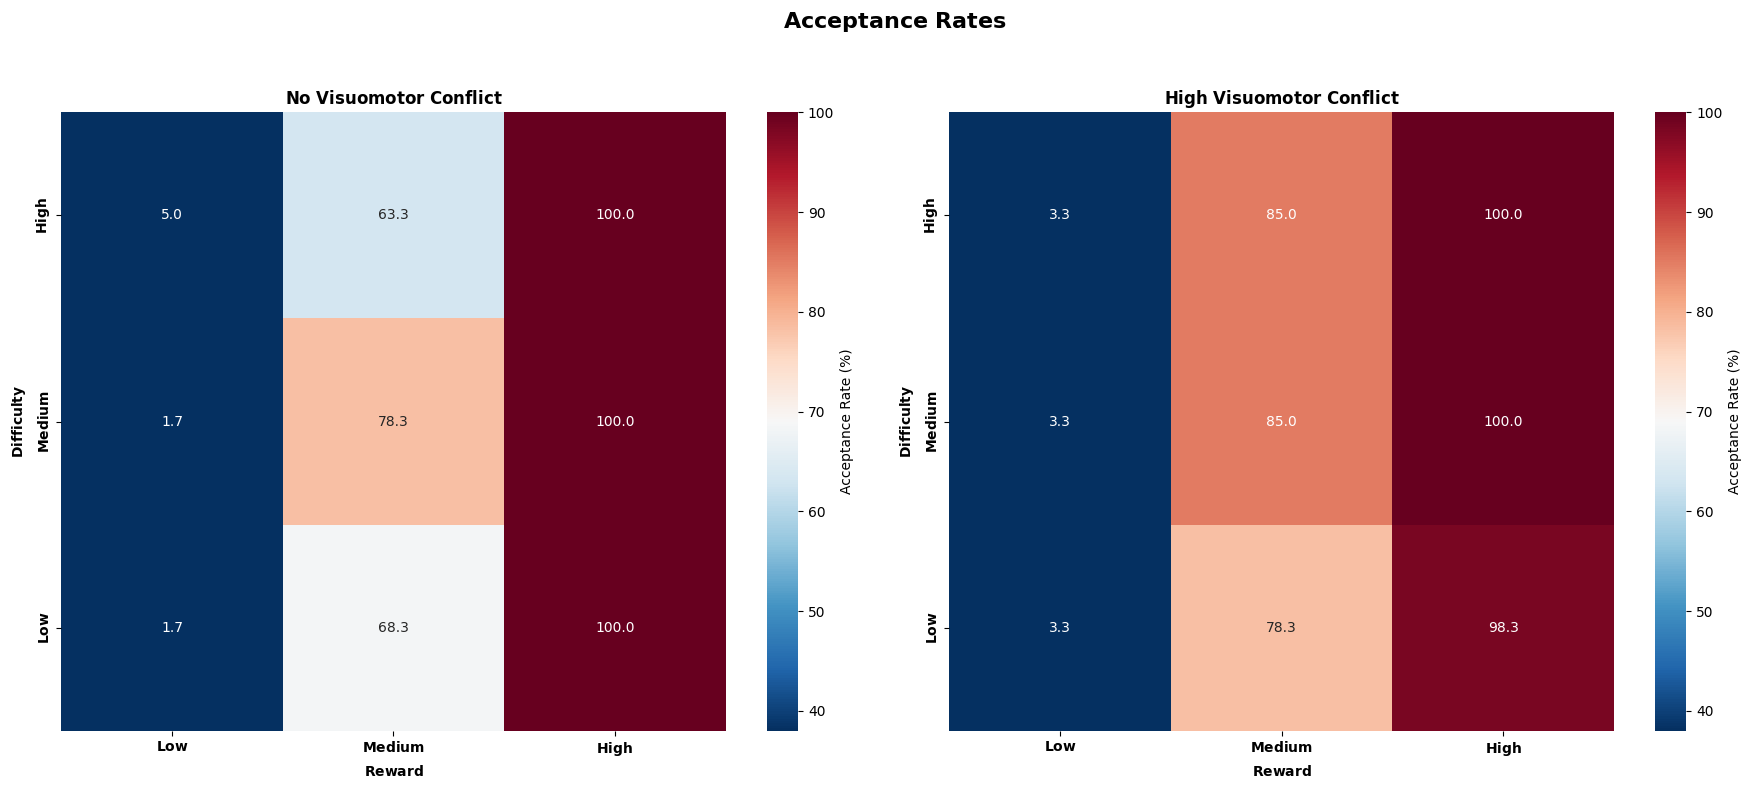

Comparing acceptance rate differences between Low Agency and High Agency:
Reward: High, Difficulty: High - Difference: 0.0000
Reward: High, Difficulty: Low - Difference: 1.6667
Reward: High, Difficulty: Medium - Difference: 0.0000
Reward: Low, Difficulty: High - Difference: 1.6667
Reward: Low, Difficulty: Low - Difference: 1.6667
Reward: Low, Difficulty: Medium - Difference: 1.6667
Reward: Medium, Difficulty: High - Difference: 21.6667
Reward: Medium, Difficulty: Low - Difference: 10.0000
Reward: Medium, Difficulty: Medium - Difference: 6.6667

Acceptance rate throughout the experience : 


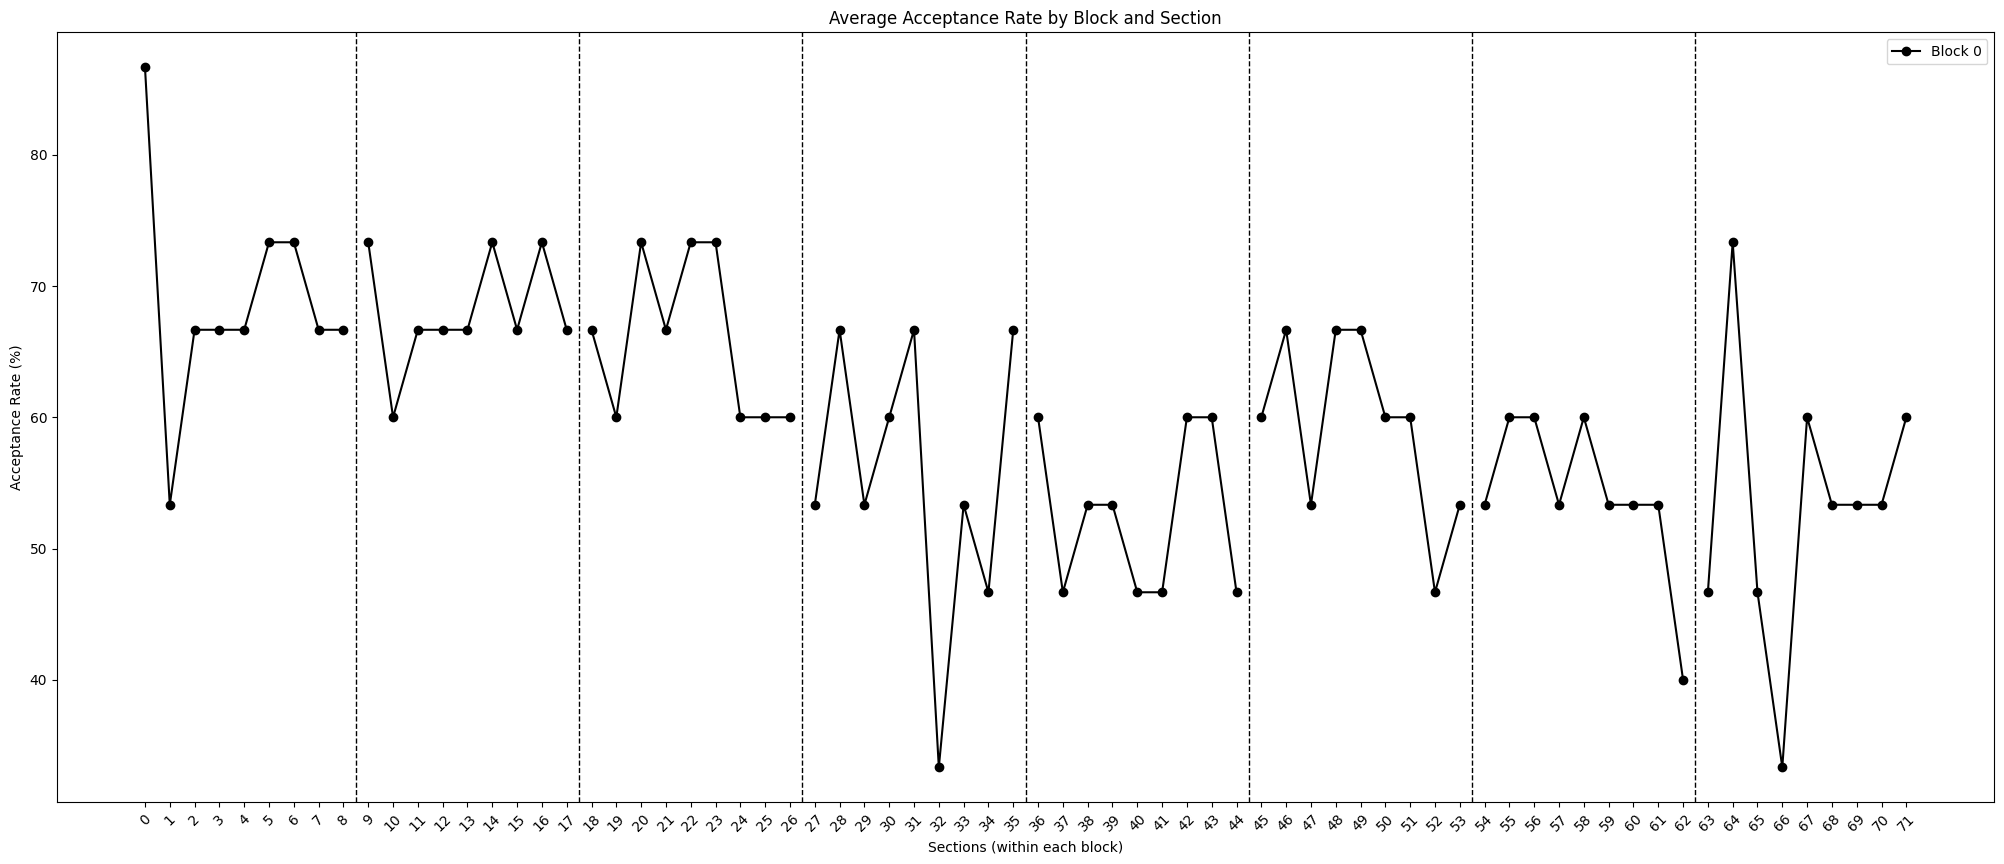

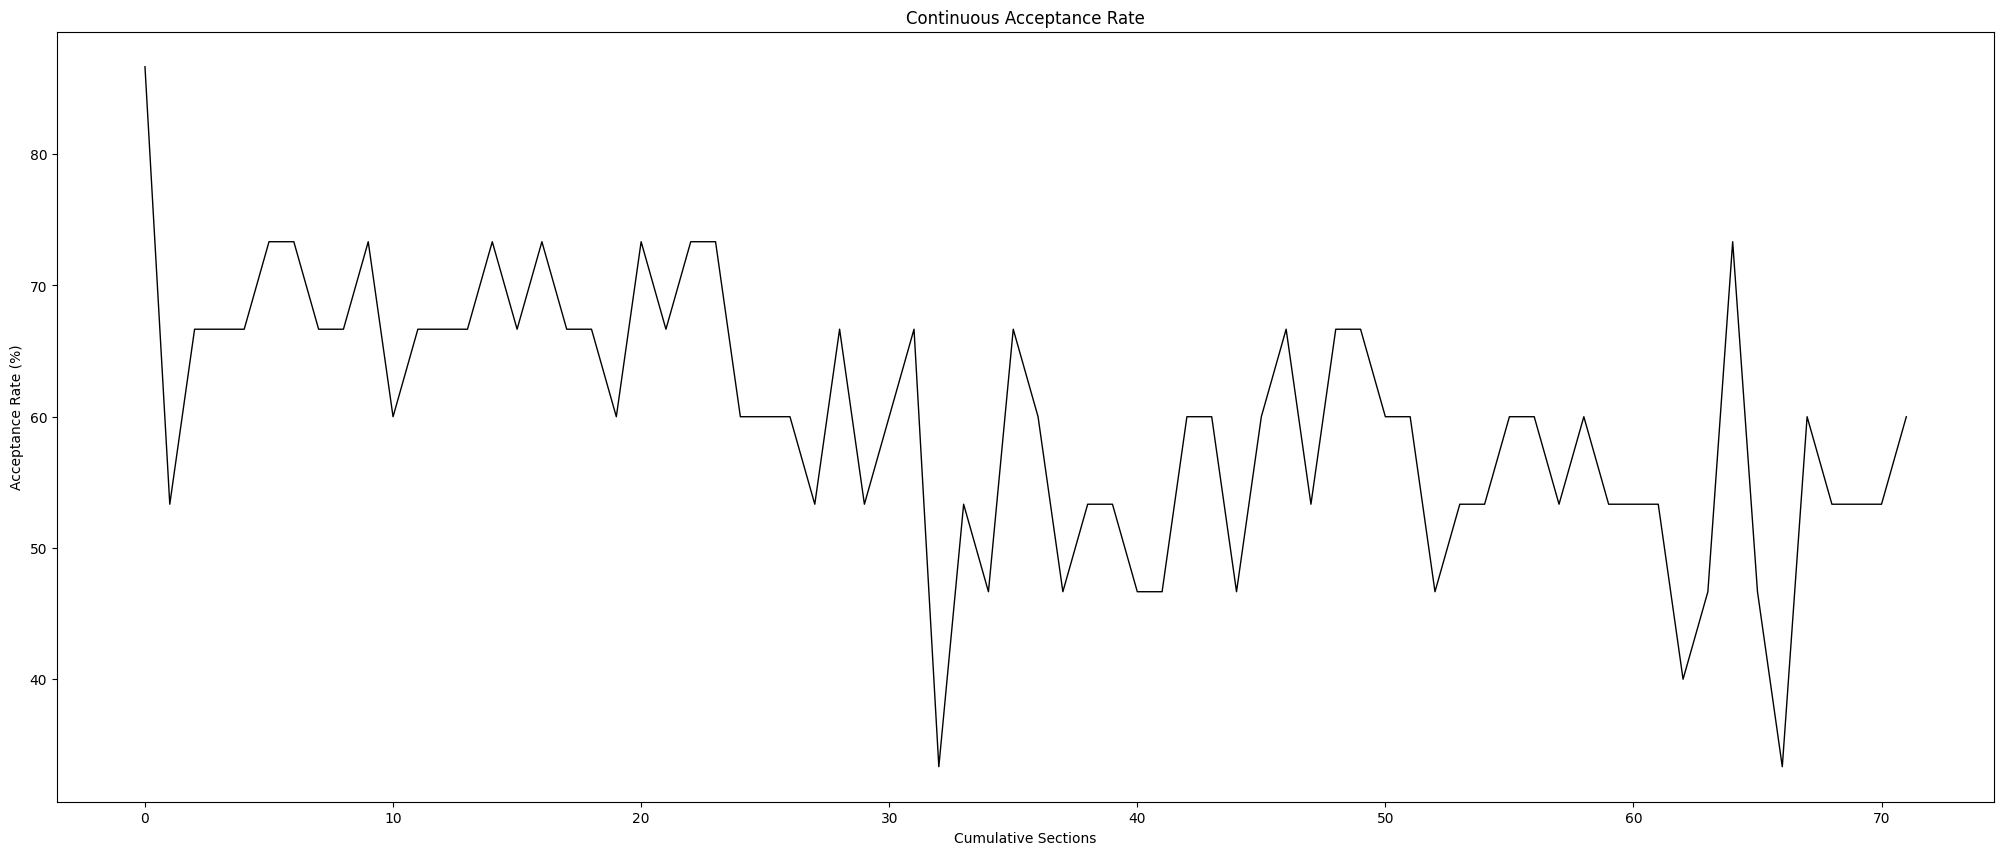

Found file: data_P03.json
Processing file: /Users/marr/Documents/EPFL/Projet_bach/participants_data/data_P03.json.csv
Acceptance rate for each combinations: 


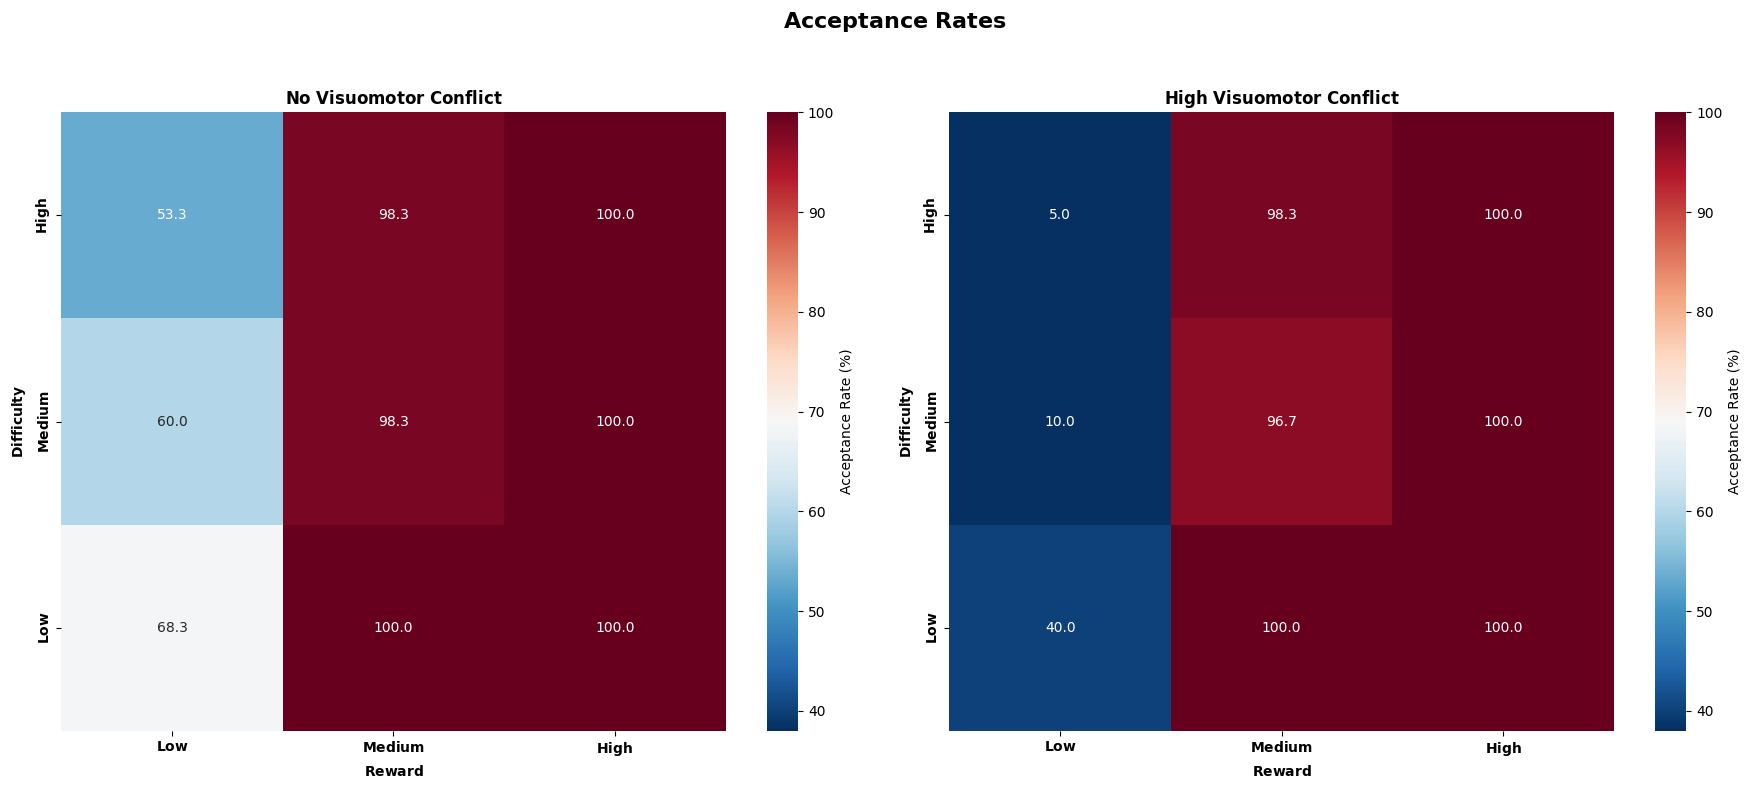

Comparing acceptance rate differences between Low Agency and High Agency:
Reward: High, Difficulty: High - Difference: 0.0000
Reward: High, Difficulty: Low - Difference: 0.0000
Reward: High, Difficulty: Medium - Difference: 0.0000
Reward: Low, Difficulty: High - Difference: 48.3333
Reward: Low, Difficulty: Low - Difference: 28.3333
Reward: Low, Difficulty: Medium - Difference: 50.0000
Reward: Medium, Difficulty: High - Difference: 0.0000
Reward: Medium, Difficulty: Low - Difference: 0.0000
Reward: Medium, Difficulty: Medium - Difference: 1.6667

Acceptance rate throughout the experience : 


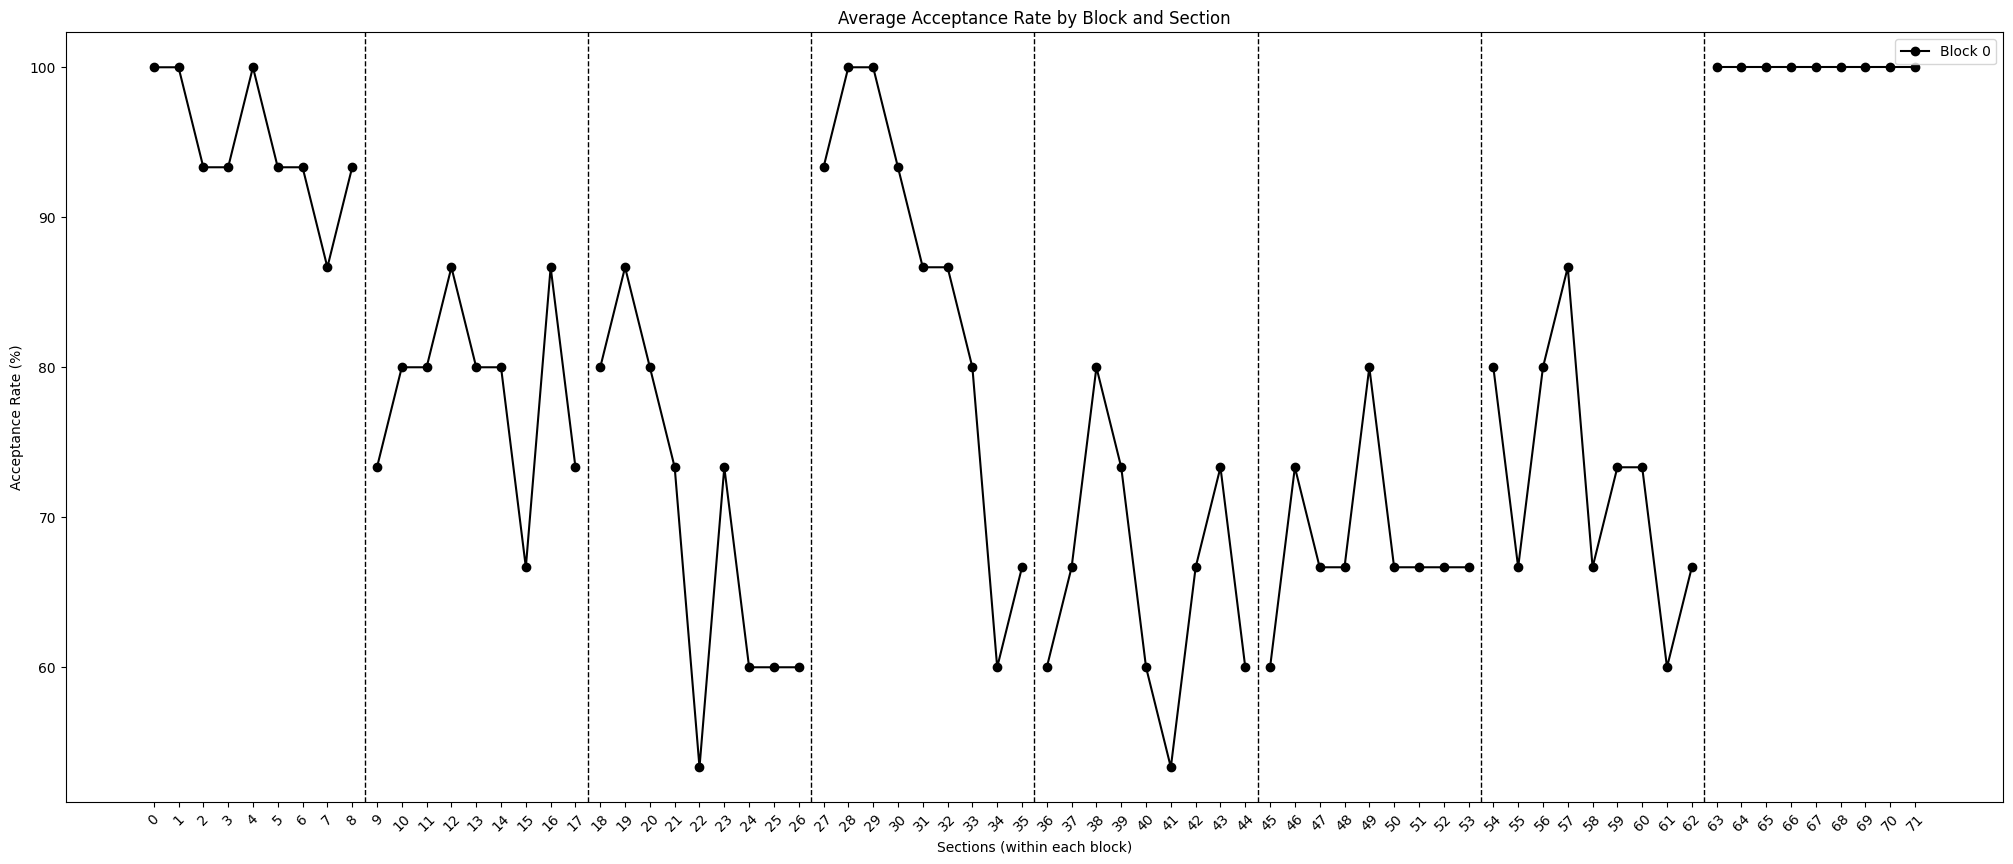

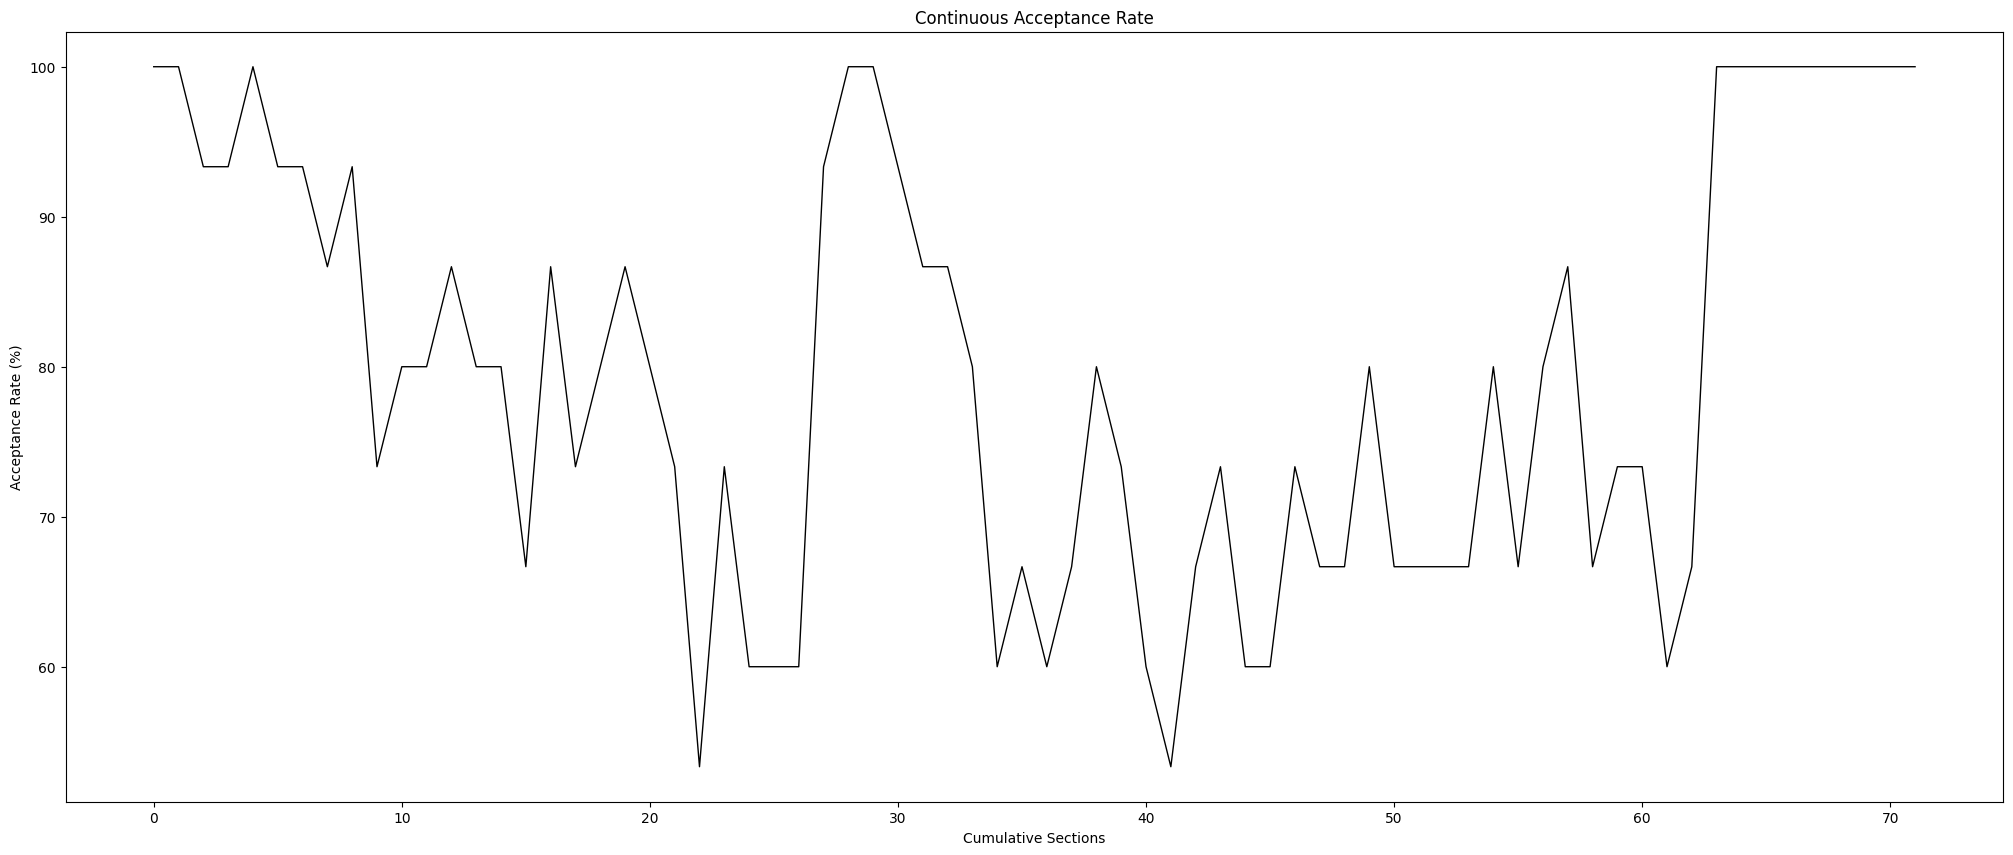

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# Directory where json files are stored
folder_path = os.path.expanduser('~/Documents/EPFL/Projet_bach/participants_data') # Replace with your actual directory

# Reward categories
LOW_REWARDS = [1, 2, 3]
MEDIUM_REWARDS = [9, 10, 11]
HIGH_REWARDS = [24, 25, 26]

def categorize_reward(reward):
    if reward in LOW_REWARDS:
        return 'Low'
    elif reward in MEDIUM_REWARDS:
        return 'Medium'
    elif reward in HIGH_REWARDS:
        return 'High'
    else:
        return 'Other'


# Check if the data folder exists
if not os.path.exists(folder_path):
    print("Data folder does not exist.")
else:
    print(f"Accessing data folder: {folder_path}")

# Loop through all files in the data folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        print(f"Found file: {filename}")
        json_path = os.path.join(folder_path, filename)
        
        with open(json_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)
            # Convert JSON data into a DataFrame 
            df = pd.DataFrame(data)

        # Save the DataFrame as a CSV file
        df.to_csv(f'{filename}.csv', index=False)
        file_path = os.path.join(folder_path, f'{filename}.csv')
        print(f"Processing file: {file_path}")

        # Read CSV file into DataFrame
        df = pd.read_csv(file_path)


        ### Analysis 1 ###
        print('Acceptance rate for each combinations: ')

        # Step 1: Filter for task = 'accept' - only processing these trials
        df_accept = df[df['task'] == 'accept'].copy()

        # Step 2: Group by unique delay values
        unique_delays = df_accept['delay'].unique()

        # Dictionary to hold combined data for each delay
        combined_data = {}
        
        for delay in unique_delays:
            # Step 3: Process each delay group independently
            df_delay = df_accept[df_accept['delay'] == delay].copy()

            # Directly use 'originalBounds' without converting to strings
            df_delay['bounds_group'] = df_delay['originalBounds']

            # Categorize rewards based on values in the 'reward' column
            df_delay['reward_group'] = df_delay['reward'].apply(categorize_reward)

            # Filter directly for accepted trials (response == 'ArrowRight')
            df_accepted = df_delay[df_delay['response'] == 'ArrowRight']

            # Calculate total trials and accepted trials by reward and bounds group
            total_trials = df_delay.groupby(['reward_group', 'bounds_group']).size().reset_index(name='total')
            accepted_trials = df_accepted.groupby(['reward_group', 'bounds_group']).size().reset_index(name='accepted')

            # Initialize or update the combined data for this delay
            if delay not in combined_data:
                combined_data[delay] = {'total': total_trials, 'accepted': accepted_trials}
            else:
                # Merge and sum the data with existing data for this delay
                combined_data[delay]['total'] = combined_data[delay]['total'].merge(total_trials, on=['reward_group', 'bounds_group'], how='outer', suffixes=('', '_file'))
                combined_data[delay]['accepted'] = combined_data[delay]['accepted'].merge(accepted_trials, on=['reward_group', 'bounds_group'], how='outer', suffixes=('', '_file'))

                combined_data[delay]['total']['total'] = combined_data[delay]['total'][['total', 'total_file']].sum(axis=1)
                combined_data[delay]['accepted']['accepted'] = combined_data[delay]['accepted'][['accepted', 'accepted_file']].sum(axis=1)

                combined_data[delay]['total'].drop(columns=['total_file'], inplace=True)
                combined_data[delay]['accepted'].drop(columns=['accepted_file'], inplace=True)

        # Create a grid of subplots
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Titles corresponding to delays
        plot_titles = {
            '[0, 0]': r"$\bf{No\ Visuomotor\ Conflict}$",
            '[0, 1000]': r"$\bf{High\ Visuomotor\ Conflict}$",
        }

        # Define color map and fixed color range for all heatmaps
        cmap = 'RdBu_r'
        vmin, vmax = 38, 100  # Fixed range for percentage acceptance rates

        # Iterate over the specified delays in the desired order
        for i, delay in enumerate(['[0, 0]','[0, 1000]']):
            if delay in combined_data:
                data = combined_data[delay]
                
                # Merge to calculate acceptance rate
                acceptance_rate = pd.merge(data['total'], data['accepted'], on=['reward_group', 'bounds_group'], how='left')
                acceptance_rate['accepted'] = acceptance_rate['accepted'].fillna(0)
                acceptance_rate['acceptance_rate'] = (acceptance_rate['accepted'] / acceptance_rate['total']) * 100  # Convert to percentage

                # Set categorical order for heatmap
                reward_order = ['Low', 'Medium', 'High']
                bounds_order = ['[70, 90]', '[45, 65]', '[20, 40]']
                acceptance_rate['reward_group'] = pd.Categorical(acceptance_rate['reward_group'], categories=reward_order, ordered=True)
                acceptance_rate['bounds_group'] = pd.Categorical(acceptance_rate['bounds_group'], categories=bounds_order, ordered=True)

                # Generate the heatmap for this delay
                heatmap_data = acceptance_rate.pivot(index='bounds_group', columns='reward_group', values='acceptance_rate')

                if not heatmap_data.empty and heatmap_data.notna().any().any():
                    sns.heatmap(
                        heatmap_data, 
                        annot=True, 
                        cmap=cmap, 
                        cbar_kws={'label': 'Acceptance Rate (%)'}, 
                        ax=axes[i], 
                        vmin=vmin, 
                        vmax=vmax, 
                        fmt=".1f"  # Format numbers with one decimal place
                    )
                    axes[i].set_title(plot_titles[delay])
                    axes[i].set_xlabel(r"$\bf{Reward}$")
                    axes[i].set_ylabel(r"$\bf{Difficulty}$")
                    axes[i].set_xticklabels([r"$\bf{Low}$", r"$\bf{Medium}$", r"$\bf{High}$"])
                    axes[i].set_yticklabels([r"$\bf{High}$", r"$\bf{Medium}$", r"$\bf{Low}$"])
                else:
                    print(f"No valid data to plot for delay: {delay} in combined data.")

        # Set the super title for the whole figure
        plt.suptitle(r"$\bf{Acceptance\ Rates}$", fontsize=16)

        # Adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # The rect parameter adjusts the space for the super title

        # Show the combined plot
        plt.show()

        # Update bounds mapping to corresponding labels
        bounds_mapping = {
            '[70, 90]': 'High',
            '[45, 65]': 'Medium',
            '[20, 40]': 'Low'}

        # Replace the numeric bounds with the corresponding labels in your combined data
        for delay in combined_data.keys():
            combined_data[delay]['total']['bounds_group'] = combined_data[delay]['total']['bounds_group'].map(bounds_mapping)
            combined_data[delay]['accepted']['bounds_group'] = combined_data[delay]['accepted']['bounds_group'].map(bounds_mapping)

        # Function to compare and print all differences between two acceptance rate heatmaps
        def compare_and_print_all_differences(rate_map1, rate_map2, delay1, delay2):
            # Calculate the absolute differences between the two acceptance rate heatmaps
            difference = rate_map1.subtract(rate_map2).abs()
            
            # Print all differences
            print(f"Comparing acceptance rate differences between {delay1} and {delay2}:")
            for idx in difference.stack().index:
                reward_group, bounds_group = idx
                diff_value = difference.at[bounds_group, reward_group]
                print(f"Reward: {reward_group}, Difficulty: {bounds_group} - Difference: {diff_value:.4f}")
            print()

        # Generate the acceptance rate heatmaps for each delay using labels
        heatmap_low = combined_data['[0, 1000]']['total'].merge(
            combined_data['[0, 1000]']['accepted'], on=['reward_group', 'bounds_group'], suffixes=('_total', '_accepted')
        )
        heatmap_low['acceptance_rate'] = (heatmap_low['accepted'] / heatmap_low['total'])*100
        heatmap_low = heatmap_low.pivot(index='bounds_group', columns='reward_group', values='acceptance_rate')

        heatmap_high = combined_data['[0, 0]']['total'].merge(
            combined_data['[0, 0]']['accepted'], on=['reward_group', 'bounds_group'], suffixes=('_total', '_accepted')
        )
        heatmap_high['acceptance_rate'] = (heatmap_high['accepted'] / heatmap_high['total'])*100
        heatmap_high = heatmap_high.pivot(index='bounds_group', columns='reward_group', values='acceptance_rate')

        # Compare Low vs High
        compare_and_print_all_differences(heatmap_low, heatmap_high, 'Low Agency', 'High Agency')


        ### Analysis 2 ###
        print('Acceptance rate throughout the experience : ')

        # Step 1: Filter for accepted trials
        df_accept = df[df['accepted'].notna()].copy()
        num_rows = len(df_accept)
        
        if num_rows == 0:
            print(f"Skipping {filename}, no valid 'accepted' data.")
            continue

        block_size = num_rows // 8  # Divide into 8 blocks

        # Step 2: Create 8 ordered blocks
        blocks = [
            df_accept.iloc[i * block_size: (i + 1) * block_size] for i in range(7)
        ] + [df_accept.iloc[7 * block_size:]]  # Last block includes remainder

        results = []
        for block_index, block_data in enumerate(blocks):
            for section_index in range(9):
                section_data = block_data.iloc[section_index * 15:(section_index + 1) * 15]
                if len(section_data) == 0:
                    continue
                acceptance_rate = section_data['accepted'].sum() / len(section_data) * 100
                results.append({
                    'block_index': block_index,
                    'section_index': section_index,
                    'acceptance %': acceptance_rate
                })

        result_df = pd.DataFrame(results)
        if result_df.empty:
            print(f"Skipping {filename}, no valid sections found.")
            continue

        # Step 3: Compute mean acceptance % by block and section
        average_acceptance_df = result_df.groupby(['block_index', 'section_index'], as_index=False)['acceptance %'].mean()

        # Figures
        plt.figure(figsize=(25, 10))

        # Plot each block separately
        for block_index in sorted(average_acceptance_df['block_index'].unique()):
            block_data = average_acceptance_df[average_acceptance_df['block_index'] == block_index]
            x_positions = [block_index * 9 + section for section in block_data['section_index']]
            plt.plot(x_positions, block_data['acceptance %'], marker='o', color='black', label=f'Block {block_index}' if block_index == 0 else "")

        # Add vertical lines to separate blocks
        for block_index in range(1, average_acceptance_df['block_index'].max() + 1):
            plt.axvline(x=block_index * 9 - 0.5, color='black', linestyle='--', linewidth=1)

        plt.title(f'Average Acceptance Rate by Block and Section')
        plt.xlabel('Sections (within each block)')
        plt.ylabel('Acceptance Rate (%)')
        plt.xticks(range(0, 9 * (average_acceptance_df['block_index'].max() + 1)), rotation=45)
        plt.legend()
        
        # Use non-blocking display
        plt.pause(0.01)
        plt.close() 

        # Continuous plot 
        plt.figure(figsize=(25, 10))
        average_acceptance_df['x_position'] = average_acceptance_df['block_index'] * 9 + average_acceptance_df['section_index']
        plt.plot(
            average_acceptance_df['x_position'],
            average_acceptance_df['acceptance %'],
            color='black',
            linestyle='-',
            linewidth=1
        )
        plt.title(f'Continuous Acceptance Rate')
        plt.xlabel('Cumulative Sections')
        plt.ylabel('Acceptance Rate (%)')
        
        plt.pause(0.01)
        plt.close()  



